In [1]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sun Aug 03 06:04:08 PM 2025"

In [2]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,656842,35.1,1439211,76.9,1439211,76.9
Vcells,1224853,9.4,8388608,64.0,1924961,14.7


In [3]:
# Paso 1: Instalación de paquetes necesarios
if (!require("lightgbm")) install.packages("lightgbm")
if (!require("mlrMBO")) install.packages("mlrMBO")
if (!require("data.table")) install.packages("data.table")

library(lightgbm)
library(mlrMBO)
library(data.table)
library(parallel)
library(smoof)
library(mlr)
library(ggplot2)

Loading required package: lightgbm

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Loading required package: smoof

Loading required package: checkmate

Loading required package: data.table



In [4]:
# Se convierte el dataset iris en una tarea binaria
# La clase "virginica" será 1 y las demás serán 0
iris_bin <- as.data.table(iris)
iris_bin[, target := ifelse(Species == "virginica", 1L, 0L)]
iris_bin[, Species := NULL]

In [5]:
# Separamos 70% para entrenamiento y 30% para validación
set.seed(123)
idx_train <- sample(1:nrow(iris_bin), 0.7 * nrow(iris_bin))
train <- iris_bin[idx_train]
test <- iris_bin[-idx_train]

In [6]:
dtrain <- lgb.Dataset(data = data.matrix(train[, !"target", with=FALSE]),
                      label = train$target)
nrow(dtrain)
ncol(dtrain)

[1] 105

[1] 4

In [7]:
param_base <- list(objective = "binary",
                   metric = "auc",
                   verbosity = -1,
                   feature_pre_filter = FALSE)

In [8]:
# Paso 6: Definición del espacio de búsqueda para Bayesian Optimization
ps <- makeParamSet(
  makeNumericParam("learning_rate", lower = 0.01, upper = 0.2),
  makeIntegerParam("num_leaves", lower = 10L, upper = 100L),
  makeIntegerParam("min_data_in_leaf", lower = 5L, upper = 50L)
)


In [9]:
# Paso 7: Definición de la función objetivo
# Se maximiza el AUC promedio de un cross-validation con 3 folds
obj_fun <- makeSingleObjectiveFunction(
  fn = function(x) {
    x <- as.list(x)
    param <- modifyList(param_base, x)
    cv <- lgb.cv(params = param,
                 data = dtrain,
                 nfold = 3,
                 nrounds = 100,
                 early_stopping_rounds = 10,
                 verbose = -1)
    return(max(unlist(cv$record_evals$valid$auc$eval)))
  },
  par.set = ps,
  minimize = FALSE
)

In [10]:
ctrl <- makeMBOControl()
ctrl <- setMBOControlTermination(ctrl, iters = 100)  # número de iteraciones
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI())

In [11]:
surrogate <- makeLearner("regr.km", predict.type = "se")

In [12]:
run <- mbo(obj_fun, learner = surrogate, control = ctrl)

Computing y column(s) for design. Not provided.

[mbo] 0: learning_rate=0.136; num_leaves=78; min_data_in_leaf=27 : y = 0.982 : 0.2 secs : initdesign

[mbo] 0: learning_rate=0.0523; num_leaves=66; min_data_in_leaf=41 : y = 0.5 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.143; num_leaves=59; min_data_in_leaf=34 : y = 0.891 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.173; num_leaves=28; min_data_in_leaf=21 : y = 0.994 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.0866; num_leaves=35; min_data_in_leaf=50 : y = 0.5 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0598; num_leaves=99; min_data_in_leaf=37 : y = 0.5 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0922; num_leaves=89; min_data_in_leaf=12 : y = 0.99 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.119; num_leaves=21; min_data_in_leaf=17 : y = 0.993 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.0149; num_leaves=17; min_data_in_leaf=6 : y = 0.967 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.158; num_le


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3634012 164 88 
  - best initial criterion value(s) :  8.538131 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -8.5381  |proj g|=     0.084911
At iterate     1  f =      -8.5576  |proj g|=      0.081257
At iterate     2  f =      -8.6204  |proj g|=       0.04403
At iterate     3  f =      -8.6506  |proj g|=     0.0074206
At iterate     4  f =      -8.6516  |proj g|=      0.002045
At iterate     5  f =      -8.6517  |proj g|=     0.0020186
At iterate     6  f =      -8.6517  |proj g|=     0.0020076
At iterate     7  f =      -8.6517  |proj g|=     0.0019586
At iterate     8  f =      -8.6519  |proj g|=     0.0025045
At iterate     9

[mbo] 1: learning_rate=0.133; num_leaves=40; min_data_in_leaf=27 : y = 0.993 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3634012 164 88 
  - best initial criterion value(s) :  7.209885 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -7.2099  |proj g|=      0.75428
At iterate     1  f =      -8.2175  |proj g|=       0.53013
At iterate     2  f =      -8.5055  |proj g|=       0.33657
At iterate     3  f =      -8.7541  |proj g|=       0.10926
At iterate     4  f =      -8.7944  |proj g|=      0.037498
At iterate     5  f =      -8.8009  |proj g|=     0.0077776
At iterate     6  f =      -8.8012  |proj g|=     0.0073522
At iterate     7  f =      -8.8012  |proj g|=     0.0073981
At iterate     8  f =      -8.8013  |proj g|=     0.0074536
At iterate     9

[mbo] 2: learning_rate=0.0383; num_leaves=63; min_data_in_leaf=19 : y = 0.971 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3634012 164 88 
  - best initial criterion value(s) :  7.627615 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -7.6276  |proj g|=      0.17415
At iterate     1  f =      -8.1468  |proj g|=       0.14931
At iterate     2  f =      -10.406  |proj g|=        0.1273
At iterate     3  f =      -10.819  |proj g|=      0.096275
At iterate     4  f =      -10.966  |proj g|=      0.030314
At iterate     5  f =       -10.97  |proj g|=      0.025002
At iterate     6  f =      -10.975  |proj g|=     0.0025115
At iterate     7  f =      -10.975  |proj g|=     0.0011714
At iterate     8  f =      -10.975  |proj g|=     0.0011666
At iterate     9

[mbo] 3: learning_rate=0.2; num_leaves=92; min_data_in_leaf=18 : y = 0.995 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702371 164 88 
  - best initial criterion value(s) :  12.10277 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -12.103  |proj g|=     0.085504
At iterate     1  f =      -12.405  |proj g|=       0.11994
At iterate     2  f =      -12.484  |proj g|=       0.10125
At iterate     3  f =      -12.606  |proj g|=      0.032496
At iterate     4  f =      -12.613  |proj g|=      0.016619
At iterate     5  f =      -12.615  |proj g|=     0.0033033
At iterate     6  f =      -12.615  |proj g|=     0.0032712
At iterate     7  f =      -12.615  |proj g|=      0.003262
At iterate     8  f =      -12.615  |proj g|=     0.0032235
At iterate     9

[mbo] 4: learning_rate=0.2; num_leaves=92; min_data_in_leaf=5 : y = 0.979 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702371 164 90 
  - best initial criterion value(s) :  11.61898 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -11.619  |proj g|=      0.65687
At iterate     1  f =      -12.338  |proj g|=       0.55242
At iterate     2  f =       -13.14  |proj g|=       0.23408
At iterate     3  f =      -13.379  |proj g|=      0.073715
At iterate     4  f =      -13.419  |proj g|=      0.031797
At iterate     5  f =      -13.424  |proj g|=      0.031455
At iterate     6  f =      -13.425  |proj g|=      0.031321
At iterate     7  f =      -13.427  |proj g|=      0.031043
At iterate     8  f =      -13.432  |proj g|=      0.030419
At iterate     9

[mbo] 5: learning_rate=0.2; num_leaves=10; min_data_in_leaf=31 : y = 0.986 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702371 178 90 
  - best initial criterion value(s) :  12.89218 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -12.892  |proj g|=      0.19997
At iterate     1  f =      -14.207  |proj g|=       0.17948
At iterate     2  f =       -15.06  |proj g|=         0.115
At iterate     3  f =      -15.205  |proj g|=      0.027424
At iterate     4  f =      -15.209  |proj g|=      0.016255
At iterate     5  f =      -15.211  |proj g|=      0.016203
At iterate     6  f =      -15.214  |proj g|=      0.016047
At iterate     7  f =      -15.223  |proj g|=      0.028407
At iterate     8  f =      -15.249  |proj g|=      0.057193
At iterate     9

[mbo] 6: learning_rate=0.2; num_leaves=53; min_data_in_leaf=29 : y = 0.977 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702371 178 90 
  - best initial criterion value(s) :  16.29353 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -16.294  |proj g|=      0.12971
At iterate     1  f =      -17.259  |proj g|=      0.060362
At iterate     2  f =      -17.274  |proj g|=       0.03842
At iterate     3  f =      -17.287  |proj g|=      0.011239
At iterate     4  f =      -17.287  |proj g|=      0.011287
At iterate     5  f =      -17.289  |proj g|=      0.011476
At iterate     6  f =      -17.294  |proj g|=      0.022074
At iterate     7  f =      -17.306  |proj g|=      0.038835
At iterate     8  f =      -17.334  |proj g|=        0.0571
At iterate     9

[mbo] 7: learning_rate=0.2; num_leaves=10; min_data_in_leaf=8 : y = 0.99 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702416 178 90 
  - best initial criterion value(s) :  17.7173 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -17.717  |proj g|=      0.16316
At iterate     1  f =      -18.818  |proj g|=       0.15936
At iterate     2  f =       -18.88  |proj g|=       0.11556
At iterate     3  f =      -18.958  |proj g|=      0.017052
At iterate     4  f =      -18.961  |proj g|=      0.016749
At iterate     5  f =      -18.963  |proj g|=      0.016505
At iterate     6  f =       -18.97  |proj g|=      0.020797
At iterate     7  f =      -18.985  |proj g|=      0.038343
At iterate     8  f =      -19.019  |proj g|=      0.055725
At iterate     9 

[mbo] 8: learning_rate=0.0319; num_leaves=10; min_data_in_leaf=30 : y = 0.968 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702416 178 90 
  - best initial criterion value(s) :  19.98721 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -19.987  |proj g|=      0.24049
At iterate     1  f =      -20.068  |proj g|=       0.23723
At iterate     2  f =      -20.688  |proj g|=      0.047333
At iterate     3  f =      -20.694  |proj g|=      0.046529
At iterate     4  f =      -20.704  |proj g|=      0.031576
At iterate     5  f =      -20.722  |proj g|=      0.031048
At iterate     6  f =      -20.858  |proj g|=       0.09118
At iterate     7  f =      -20.998  |proj g|=       0.10354
At iterate     8  f =      -21.129  |proj g|=      0.046001
At iterate     9

[mbo] 9: learning_rate=0.133; num_leaves=58; min_data_in_leaf=8 : y = 0.995 : 0.6 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702416 178 90 
  - best initial criterion value(s) :  22.63451 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -22.635  |proj g|=     0.078698
At iterate     1  f =      -23.423  |proj g|=      0.028536
At iterate     2  f =      -23.425  |proj g|=      0.023636
At iterate     3  f =      -23.429  |proj g|=      0.010332
At iterate     4  f =      -23.448  |proj g|=      0.028579
At iterate     5  f =      -23.504  |proj g|=      0.055107
At iterate     6  f =      -23.536  |proj g|=       0.02986
At iterate     7  f =       -23.54  |proj g|=     0.0074498
At iterate     8  f =       -23.54  |proj g|=     0.0002008
At iterate     9

[mbo] 10: learning_rate=0.145; num_leaves=72; min_data_in_leaf=22 : y = 0.947 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702416 178 90 
  - best initial criterion value(s) :  20.52386 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -20.524  |proj g|=      0.20608
At iterate     1  f =      -23.228  |proj g|=       0.12055
At iterate     2  f =      -23.272  |proj g|=      0.075464
At iterate     3  f =      -23.299  |proj g|=      0.039164
At iterate     4  f =      -23.302  |proj g|=       0.03799
At iterate     5  f =      -23.309  |proj g|=      0.036518
At iterate     6  f =      -23.331  |proj g|=      0.044203
At iterate     7  f =      -23.407  |proj g|=       0.10687
At iterate     8  f =      -23.532  |proj g|=        0.1621
At iterate     9

[mbo] 11: learning_rate=0.2; num_leaves=10; min_data_in_leaf=19 : y = 0.991 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702416 178 90 
  - best initial criterion value(s) :  22.86832 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -22.868  |proj g|=      0.48398
At iterate     1  f =      -25.975  |proj g|=       0.62846
At iterate     2  f =      -26.199  |proj g|=       0.55598
At iterate     3  f =      -26.682  |proj g|=       0.21462
At iterate     4  f =      -26.722  |proj g|=        0.1298
At iterate     5  f =      -26.738  |proj g|=      0.015691
At iterate     6  f =      -26.738  |proj g|=     0.0034419
At iterate     7  f =      -26.738  |proj g|=      0.003478
At iterate     8  f =      -26.738  |proj g|=     0.0075089
At iterate     9

[mbo] 12: learning_rate=0.182; num_leaves=100; min_data_in_leaf=15 : y = 0.997 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702416 180 90 
  - best initial criterion value(s) :  26.53437 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -26.534  |proj g|=       1.2623
At iterate     1  f =      -28.767  |proj g|=       0.48727
At iterate     2  f =      -29.018  |proj g|=       0.07603
At iterate     3  f =      -29.025  |proj g|=      0.014723
At iterate     4  f =      -29.026  |proj g|=     0.0061257
At iterate     5  f =      -29.026  |proj g|=     0.0060288
At iterate     6  f =      -29.027  |proj g|=      0.016501
At iterate     7  f =      -29.029  |proj g|=      0.032034
At iterate     8  f =      -29.034  |proj g|=      0.056834
At iterate     9

[mbo] 13: learning_rate=0.2; num_leaves=100; min_data_in_leaf=10 : y = 0.994 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702416 180 90 
  - best initial criterion value(s) :  29.41197 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -29.412  |proj g|=      0.13066
At iterate     1  f =      -31.129  |proj g|=      0.060821
At iterate     2  f =       -31.13  |proj g|=      0.051272
At iterate     3  f =      -31.135  |proj g|=      0.010386
At iterate     4  f =      -31.136  |proj g|=      0.010249
At iterate     5  f =      -31.137  |proj g|=      0.018179
At iterate     6  f =       -31.14  |proj g|=      0.035859
At iterate     7  f =      -31.148  |proj g|=      0.065527
At iterate     8  f =      -31.166  |proj g|=       0.10123
At iterate     9

[mbo] 14: learning_rate=0.18; num_leaves=60; min_data_in_leaf=17 : y = 0.994 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3702416 180 90 
  - best initial criterion value(s) :  29.6059 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -29.606  |proj g|=      0.42501
At iterate     1  f =      -32.083  |proj g|=       0.50464
At iterate     2  f =       -32.52  |proj g|=       0.43744
At iterate     3  f =      -33.324  |proj g|=      0.043798
At iterate     4  f =       -33.33  |proj g|=       0.04507
At iterate     5  f =      -33.333  |proj g|=        0.0443
At iterate     6  f =      -33.336  |proj g|=      0.043619
At iterate     7  f =      -33.351  |proj g|=      0.042836
At iterate     8  f =      -33.381  |proj g|=      0.089099
At iterate     9 

[mbo] 15: learning_rate=0.0101; num_leaves=10; min_data_in_leaf=11 : y = 0.948 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3798985 180 90 
  - best initial criterion value(s) :  35.02568 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -35.026  |proj g|=      0.23339
At iterate     1  f =      -35.893  |proj g|=       0.15291
At iterate     2  f =      -35.913  |proj g|=       0.11402
At iterate     3  f =       -35.94  |proj g|=      0.010186
At iterate     4  f =      -35.941  |proj g|=     0.0076385
At iterate     5  f =      -35.941  |proj g|=     0.0075097
At iterate     6  f =      -35.941  |proj g|=     0.0095853
At iterate     7  f =      -35.942  |proj g|=      0.019231
At iterate     8  f =      -35.945  |proj g|=      0.034283
At iterate     9

[mbo] 16: learning_rate=0.111; num_leaves=10; min_data_in_leaf=20 : y = 0.992 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3798985 180 90 
  - best initial criterion value(s) :  36.85312 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -36.853  |proj g|=      0.30907
At iterate     1  f =      -38.853  |proj g|=        0.2456
At iterate     2  f =      -38.882  |proj g|=       0.21872
At iterate     3  f =      -38.968  |proj g|=      0.075118
At iterate     4  f =      -38.976  |proj g|=      0.015802
At iterate     5  f =      -38.976  |proj g|=     0.0025172
At iterate     6  f =      -38.976  |proj g|=     0.0025799
At iterate     7  f =      -38.976  |proj g|=      0.005394
At iterate     8  f =      -38.976  |proj g|=      0.012171
At iterate     9

[mbo] 17: learning_rate=0.2; num_leaves=10; min_data_in_leaf=25 : y = 0.994 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3798985 180 90 
  - best initial criterion value(s) :  40.82067 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -40.821  |proj g|=      0.11272
At iterate     1  f =      -41.036  |proj g|=      0.074967
At iterate     2  f =      -41.041  |proj g|=      0.055012
At iterate     3  f =      -41.048  |proj g|=     0.0043963
At iterate     4  f =      -41.048  |proj g|=     0.0042411
At iterate     5  f =      -41.048  |proj g|=     0.0041568
At iterate     6  f =      -41.048  |proj g|=     0.0053122
At iterate     7  f =      -41.048  |proj g|=      0.010397
At iterate     8  f =      -41.049  |proj g|=      0.018849
At iterate     9

[mbo] 18: learning_rate=0.2; num_leaves=10; min_data_in_leaf=5 : y = 0.979 : 0.6 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3798994 180 90 
  - best initial criterion value(s) :  42.72836 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -42.728  |proj g|=      0.26896
At iterate     1  f =       -43.31  |proj g|=        0.2362
At iterate     2  f =      -43.375  |proj g|=        0.1682
At iterate     3  f =      -43.429  |proj g|=      0.045219
At iterate     4  f =      -43.432  |proj g|=     0.0062937
At iterate     5  f =      -43.432  |proj g|=    0.00064821
At iterate     6  f =      -43.432  |proj g|=    0.00066196
At iterate     7  f =      -43.432  |proj g|=     0.0010811
At iterate     8  f =      -43.432  |proj g|=      0.002417
At iterate     9

[mbo] 19: learning_rate=0.2; num_leaves=58; min_data_in_leaf=7 : y = 0.985 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3798994 180 90 
  - best initial criterion value(s) :  40.46449 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -40.464  |proj g|=      0.12387
At iterate     1  f =      -40.615  |proj g|=      0.099398
At iterate     2  f =      -40.619  |proj g|=      0.038247
At iterate     3  f =      -40.619  |proj g|=      0.023373
At iterate     4  f =      -40.619  |proj g|=       0.02342
At iterate     5  f =      -40.619  |proj g|=       0.07359
At iterate     6  f =      -40.619  |proj g|=       0.15362
At iterate     7  f =       -40.62  |proj g|=       0.28528
At iterate     8  f =       -40.62  |proj g|=       0.28568
At iterate     9

[mbo] 20: learning_rate=0.105; num_leaves=97; min_data_in_leaf=5 : y = 0.975 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3798994 180 90 
  - best initial criterion value(s) :  45.76926 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -45.769  |proj g|=      0.65424
At iterate     1  f =      -46.864  |proj g|=       0.66653
At iterate     2  f =      -48.843  |proj g|=       0.30843
At iterate     3  f =      -49.065  |proj g|=      0.028385
At iterate     4  f =      -49.067  |proj g|=     0.0078241
At iterate     5  f =      -49.067  |proj g|=     0.0007779
At iterate     6  f =      -49.067  |proj g|=     0.0016736
At iterate     7  f =      -49.067  |proj g|=     0.0056468
At iterate     8  f =      -49.067  |proj g|=       0.01365
At iterate     9

[mbo] 21: learning_rate=0.157; num_leaves=35; min_data_in_leaf=10 : y = 0.987 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3798994 180 90 
  - best initial criterion value(s) :  44.65861 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -44.659  |proj g|=      0.60839
At iterate     1  f =      -46.579  |proj g|=       0.58914
At iterate     2  f =      -48.859  |proj g|=        0.1968
At iterate     3  f =      -49.024  |proj g|=       0.18783
At iterate     4  f =      -49.746  |proj g|=         0.168
At iterate     5  f =      -51.037  |proj g|=       0.26756
At iterate     6  f =      -51.604  |proj g|=       0.19245
At iterate     7  f =       -51.85  |proj g|=      0.066999
At iterate     8  f =       -51.91  |proj g|=     0.0098144
At iterate     9

[mbo] 22: learning_rate=0.199; num_leaves=100; min_data_in_leaf=13 : y = 0.984 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3798994 180 90 
  - best initial criterion value(s) :  51.08496 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -51.085  |proj g|=        1.171
At iterate     1  f =      -52.613  |proj g|=        1.0781
At iterate     2  f =      -54.755  |proj g|=       0.19539
At iterate     3  f =      -54.784  |proj g|=     0.0080448
At iterate     4  f =      -54.784  |proj g|=     0.0081619
At iterate     5  f =      -54.785  |proj g|=      0.013674
At iterate     6  f =      -54.786  |proj g|=      0.032777
At iterate     7  f =      -54.789  |proj g|=       0.06733
At iterate     8  f =      -54.797  |proj g|=       0.13002
At iterate     9

[mbo] 23: learning_rate=0.105; num_leaves=47; min_data_in_leaf=15 : y = 0.994 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3798994 180 90 
  - best initial criterion value(s) :  52.8721 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -52.872  |proj g|=       1.0976
At iterate     1  f =      -56.825  |proj g|=       0.97079
At iterate     2  f =      -57.948  |proj g|=       0.24887
At iterate     3  f =      -57.968  |proj g|=       0.20437
At iterate     4  f =      -57.992  |proj g|=      0.017532
At iterate     5  f =      -57.992  |proj g|=     0.0036798
At iterate     6  f =      -57.992  |proj g|=     0.0037276
At iterate     7  f =      -57.992  |proj g|=     0.0077397
At iterate     8  f =      -57.992  |proj g|=      0.016775
At iterate     9 

[mbo] 24: learning_rate=0.01; num_leaves=100; min_data_in_leaf=9 : y = 0.94 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  55.6465 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -55.647  |proj g|=      0.62294
At iterate     1  f =      -58.862  |proj g|=       0.53185
At iterate     2  f =      -59.173  |proj g|=       0.33278
At iterate     3  f =      -59.286  |proj g|=       0.19053
At iterate     4  f =      -59.318  |proj g|=      0.032283
At iterate     5  f =       -59.32  |proj g|=      0.013596
At iterate     6  f =       -59.32  |proj g|=      0.013339
At iterate     7  f =      -59.321  |proj g|=      0.019977
At iterate     8  f =      -59.323  |proj g|=      0.043728
At iterate     9 

[mbo] 25: learning_rate=0.165; num_leaves=82; min_data_in_leaf=9 : y = 0.974 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  54.52869 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -54.529  |proj g|=      0.41983
At iterate     1  f =      -56.617  |proj g|=       0.54272
At iterate     2  f =       -57.07  |proj g|=       0.47933
At iterate     3  f =      -57.984  |proj g|=       0.14649
At iterate     4  f =      -58.033  |proj g|=      0.040646
At iterate     5  f =      -58.033  |proj g|=      0.040138
At iterate     6  f =      -58.034  |proj g|=      0.039126
At iterate     7  f =      -58.037  |proj g|=      0.037752
At iterate     8  f =      -58.045  |proj g|=       0.07272
At iterate     9

[mbo] 26: learning_rate=0.0991; num_leaves=98; min_data_in_leaf=17 : y = 0.98 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  55.16408 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -55.164  |proj g|=       4.9865
At iterate     1  f =      -55.341  |proj g|=        1.6485
At iterate     2  f =      -61.044  |proj g|=       0.04289
At iterate     3  f =      -61.045  |proj g|=      0.030055
At iterate     4  f =      -61.067  |proj g|=       0.14627
At iterate     5  f =      -61.137  |proj g|=       0.30571
At iterate     6  f =      -61.147  |proj g|=       0.18667
At iterate     7  f =      -61.154  |proj g|=     0.0078609
At iterate     8  f =      -61.154  |proj g|=     0.0002202
At iterate     9

[mbo] 27: learning_rate=0.2; num_leaves=10; min_data_in_leaf=15 : y = 0.992 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  59.80895 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -59.809  |proj g|=      0.24681
At iterate     1  f =      -60.567  |proj g|=       0.28535
At iterate     2  f =      -60.614  |proj g|=       0.24228
At iterate     3  f =      -60.627  |proj g|=       0.19127
At iterate     4  f =       -60.63  |proj g|=       0.20612
At iterate     5  f =       -60.63  |proj g|=       0.20469
At iterate     6  f =      -60.631  |proj g|=       0.19948
At iterate     7  f =      -60.632  |proj g|=       0.19223
At iterate     8  f =      -60.637  |proj g|=       0.19194
At iterate     9

[mbo] 28: learning_rate=0.2; num_leaves=95; min_data_in_leaf=11 : y = 0.995 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  63.25687 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -63.257  |proj g|=       0.2075
At iterate     1  f =      -65.097  |proj g|=       0.91665
At iterate     2  f =      -66.181  |proj g|=       0.30506
At iterate     3  f =      -66.249  |proj g|=      0.035774
At iterate     4  f =       -66.25  |proj g|=     0.0047297
At iterate     5  f =       -66.25  |proj g|=    5.7779e-05
At iterate     6  f =       -66.25  |proj g|=    5.4989e-05

iterations 6
function evaluations 10
segments explored during Cauchy searches 7
BFGS updates skipped 0
active bounds at final generaliz

[mbo] 29: learning_rate=0.01; num_leaves=22; min_data_in_leaf=24 : y = 0.976 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  66.17458 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -66.175  |proj g|=      0.16862
At iterate     1  f =      -68.376  |proj g|=       0.26928
At iterate     2  f =      -68.424  |proj g|=       0.23677
At iterate     3  f =      -68.515  |proj g|=       0.16024
At iterate     4  f =      -68.545  |proj g|=      0.038688
At iterate     5  f =      -68.547  |proj g|=     0.0069394
At iterate     6  f =      -68.547  |proj g|=     0.0062972
At iterate     7  f =      -68.547  |proj g|=      0.006152
At iterate     8  f =      -68.547  |proj g|=      0.010004
At iterate     9

[mbo] 30: learning_rate=0.176; num_leaves=89; min_data_in_leaf=16 : y = 0.989 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  66.80482 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -66.805  |proj g|=      0.34006
At iterate     1  f =      -67.236  |proj g|=       0.38223
At iterate     2  f =      -70.042  |proj g|=        0.2838
At iterate     3  f =      -70.144  |proj g|=      0.062418
At iterate     4  f =      -70.147  |proj g|=      0.066302
At iterate     5  f =      -70.148  |proj g|=      0.068448
At iterate     6  f =      -70.148  |proj g|=      0.069767
At iterate     7  f =      -70.152  |proj g|=      0.073641
At iterate     8  f =       -70.16  |proj g|=      0.078605
At iterate     9

[mbo] 31: learning_rate=0.121; num_leaves=30; min_data_in_leaf=7 : y = 0.985 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  68.59557 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -68.596  |proj g|=       1.0665
At iterate     1  f =      -70.443  |proj g|=       0.43708
At iterate     2  f =      -70.454  |proj g|=       0.43228
At iterate     3  f =      -70.599  |proj g|=       0.20514
At iterate     4  f =      -70.611  |proj g|=       0.17813
At iterate     5  f =      -70.612  |proj g|=      0.033454
At iterate     6  f =      -70.612  |proj g|=      0.011718
At iterate     7  f =      -70.612  |proj g|=      0.011726
At iterate     8  f =      -70.612  |proj g|=      0.039913
At iterate     9

[mbo] 32: learning_rate=0.137; num_leaves=43; min_data_in_leaf=31 : y = 0.992 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  74.1638 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -74.164  |proj g|=      0.78359
At iterate     1  f =      -75.717  |proj g|=       0.94148
At iterate     2  f =      -77.505  |proj g|=       0.49666
At iterate     3  f =      -77.715  |proj g|=      0.060462
At iterate     4  f =      -77.718  |proj g|=      0.046327
At iterate     5  f =      -77.718  |proj g|=      0.045913
At iterate     6  f =      -77.719  |proj g|=      0.045288
At iterate     7  f =      -77.721  |proj g|=      0.045119
At iterate     8  f =      -77.726  |proj g|=      0.087007
At iterate     9 

[mbo] 33: learning_rate=0.111; num_leaves=57; min_data_in_leaf=11 : y = 0.996 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  75.14422 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -75.144  |proj g|=      0.27077
At iterate     1  f =      -75.773  |proj g|=       0.37466
At iterate     2  f =      -75.831  |proj g|=       0.51072
At iterate     3  f =      -75.837  |proj g|=        0.5716
At iterate     4  f =      -75.838  |proj g|=       0.56206
At iterate     5  f =      -75.844  |proj g|=       0.53549
At iterate     6  f =      -75.859  |proj g|=       0.49367
At iterate     7  f =      -75.896  |proj g|=        0.4259
At iterate     8  f =      -75.984  |proj g|=       0.33014
At iterate     9

[mbo] 34: learning_rate=0.169; num_leaves=10; min_data_in_leaf=29 : y = 0.993 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  75.5255 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -75.525  |proj g|=       1.1293
At iterate     1  f =      -82.938  |proj g|=       0.81548
At iterate     2  f =      -83.178  |proj g|=       0.70611
At iterate     3  f =       -83.63  |proj g|=       0.19668
At iterate     4  f =      -83.652  |proj g|=      0.085553
At iterate     5  f =      -83.656  |proj g|=     0.0059804
At iterate     6  f =      -83.656  |proj g|=     0.0039213
At iterate     7  f =      -83.656  |proj g|=      0.003966
At iterate     8  f =      -83.656  |proj g|=     0.0040058
At iterate     9 

[mbo] 35: learning_rate=0.0946; num_leaves=55; min_data_in_leaf=5 : y = 0.986 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  79.92125 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -79.921  |proj g|=      0.54378
At iterate     1  f =      -81.934  |proj g|=       0.48319
At iterate     2  f =      -86.032  |proj g|=      0.088595
At iterate     3  f =      -86.037  |proj g|=      0.036202
At iterate     4  f =      -86.037  |proj g|=      0.036641
At iterate     5  f =      -86.037  |proj g|=      0.037153
At iterate     6  f =      -86.038  |proj g|=      0.038114
At iterate     7  f =      -86.039  |proj g|=      0.039462
At iterate     8  f =      -86.044  |proj g|=      0.075928
At iterate     9

[mbo] 36: learning_rate=0.2; num_leaves=36; min_data_in_leaf=18 : y = 0.989 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  83.52786 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -83.528  |proj g|=       1.0184
At iterate     1  f =       -84.84  |proj g|=       0.67355
At iterate     2  f =      -84.975  |proj g|=       0.51309
At iterate     3  f =      -85.019  |proj g|=       0.25603
At iterate     4  f =      -85.032  |proj g|=       0.34153
At iterate     5  f =      -85.054  |proj g|=       0.34741
At iterate     6  f =      -86.026  |proj g|=        1.1596
At iterate     7  f =      -86.064  |proj g|=        1.4133
At iterate     8  f =      -87.331  |proj g|=        2.8913
At iterate     9

[mbo] 37: learning_rate=0.101; num_leaves=10; min_data_in_leaf=26 : y = 0.984 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  80.36261 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -80.363  |proj g|=      0.62846
At iterate     1  f =      -80.401  |proj g|=       0.63621
At iterate     2  f =      -80.417  |proj g|=       0.63796
At iterate     3  f =      -80.486  |proj g|=       0.64042
At iterate     4  f =      -80.642  |proj g|=       0.63845
At iterate     5  f =      -81.093  |proj g|=       0.61635
At iterate     6  f =      -82.261  |proj g|=       0.50181
At iterate     7  f =       -84.33  |proj g|=       0.33565
At iterate     8  f =      -86.272  |proj g|=        0.3164
At iterate     9

[mbo] 38: learning_rate=0.01; num_leaves=61; min_data_in_leaf=29 : y = 0.928 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  92.52073 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -92.521  |proj g|=      0.12707
At iterate     1  f =      -93.096  |proj g|=       0.13535
At iterate     2  f =      -93.961  |proj g|=      0.098327
At iterate     3  f =      -94.194  |proj g|=      0.041374
At iterate     4  f =      -94.231  |proj g|=      0.048607
At iterate     5  f =      -94.237  |proj g|=      0.012299
At iterate     6  f =      -94.238  |proj g|=     0.0019028
At iterate     7  f =      -94.238  |proj g|=    7.0026e-05
At iterate     8  f =      -94.238  |proj g|=    7.9887e-06

iterations 8
fu

[mbo] 39: learning_rate=0.2; num_leaves=98; min_data_in_leaf=26 : y = 0.992 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  87.85845 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -87.858  |proj g|=     0.089339
At iterate     1  f =      -87.876  |proj g|=       0.29671
At iterate     2  f =      -87.877  |proj g|=      0.066922
At iterate     3  f =      -87.877  |proj g|=      0.011779
At iterate     4  f =      -87.877  |proj g|=      0.015253
At iterate     5  f =      -87.877  |proj g|=      0.063209
At iterate     6  f =      -87.877  |proj g|=       0.14675
At iterate     7  f =      -87.877  |proj g|=       0.27864
At iterate     8  f =      -87.877  |proj g|=       0.29572
At iterate     9

[mbo] 40: learning_rate=0.184; num_leaves=10; min_data_in_leaf=12 : y = 0.984 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  97.43053 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -97.431  |proj g|=       1.0253
At iterate     1  f =      -97.971  |proj g|=         1.868
At iterate     2  f =      -98.328  |proj g|=       0.46815
At iterate     3  f =      -98.367  |proj g|=       0.12513
At iterate     4  f =       -98.37  |proj g|=      0.047579
At iterate     5  f =       -98.37  |proj g|=      0.047389
At iterate     6  f =      -98.371  |proj g|=       0.04674
At iterate     7  f =      -98.373  |proj g|=      0.090982
At iterate     8  f =      -98.379  |proj g|=       0.18502
At iterate     9

[mbo] 41: learning_rate=0.106; num_leaves=10; min_data_in_leaf=32 : y = 0.983 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  89.88516 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -89.885  |proj g|=      0.58042
At iterate     1  f =      -94.346  |proj g|=        1.7369
At iterate     2  f =      -96.017  |proj g|=        0.4937
At iterate     3  f =      -96.083  |proj g|=       0.42819
At iterate     4  f =      -96.092  |proj g|=       0.40878
At iterate     5  f =      -96.106  |proj g|=       0.39311
At iterate     6  f =      -96.205  |proj g|=       0.25758
At iterate     7  f =      -96.306  |proj g|=       0.19936
At iterate     8  f =      -96.473  |proj g|=       0.18447
At iterate     9

[mbo] 42: learning_rate=0.2; num_leaves=10; min_data_in_leaf=27 : y = 0.991 : 0.3 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  95.40874 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -95.409  |proj g|=      0.79836
At iterate     1  f =      -102.51  |proj g|=       0.75655
At iterate     2  f =      -103.82  |proj g|=       0.58099
At iterate     3  f =      -105.62  |proj g|=         0.146
At iterate     4  f =      -105.64  |proj g|=       0.12616
At iterate     5  f =      -105.64  |proj g|=       0.11236
At iterate     6  f =      -105.68  |proj g|=       0.10031
At iterate     7  f =      -106.72  |proj g|=       0.65464
At iterate     8  f =      -106.94  |proj g|=       0.19034
At iterate     9

[mbo] 43: learning_rate=0.131; num_leaves=26; min_data_in_leaf=30 : y = 0.968 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  90.34496 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -90.345  |proj g|=      0.36917
At iterate     1  f =      -91.766  |proj g|=       0.12256
At iterate     2  f =      -91.824  |proj g|=      0.083323
At iterate     3  f =      -91.868  |proj g|=       0.36385
At iterate     4  f =      -91.884  |proj g|=      0.039226
At iterate     5  f =      -91.886  |proj g|=      0.040583
At iterate     6  f =      -91.886  |proj g|=      0.075642
At iterate     7  f =      -91.886  |proj g|=      0.040821

iterations 7
function evaluations 11
segments explored during Cauchy search

[mbo] 44: learning_rate=0.0283; num_leaves=45; min_data_in_leaf=13 : y = 0.938 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  94.22136 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -94.221  |proj g|=      0.74519
At iterate     1  f =      -102.08  |proj g|=        0.9587
At iterate     2  f =      -106.21  |proj g|=       0.82913
At iterate     3  f =      -108.58  |proj g|=      0.068259
At iterate     4  f =      -108.59  |proj g|=      0.063393
At iterate     5  f =      -108.59  |proj g|=      0.064067
At iterate     6  f =       -108.6  |proj g|=      0.062707
At iterate     7  f =      -108.61  |proj g|=      0.052479
At iterate     8  f =      -108.63  |proj g|=      0.076048
At iterate     9

[mbo] 45: learning_rate=0.137; num_leaves=54; min_data_in_leaf=16 : y = 0.994 : 0.3 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  100.1033 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -100.1  |proj g|=       0.8233
At iterate     1  f =       -100.3  |proj g|=        0.7679
At iterate     2  f =      -100.34  |proj g|=       0.75467
At iterate     3  f =      -100.43  |proj g|=       0.74969
At iterate     4  f =      -101.25  |proj g|=       0.73502
At iterate     5  f =      -103.08  |proj g|=       0.64268
At iterate     6  f =      -104.71  |proj g|=       0.28978
At iterate     7  f =      -106.37  |proj g|=       0.46654
At iterate     8  f =       -107.7  |proj g|=       0.14901
At iterate     9

[mbo] 46: learning_rate=0.125; num_leaves=63; min_data_in_leaf=14 : y = 0.994 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  109.4099 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -109.41  |proj g|=      0.75817
At iterate     1  f =      -110.37  |proj g|=       0.22927
At iterate     2  f =       -110.4  |proj g|=       0.15722
At iterate     3  f =      -110.42  |proj g|=      0.030624
At iterate     4  f =      -110.42  |proj g|=      0.026764
At iterate     5  f =      -110.42  |proj g|=      0.026517
At iterate     6  f =      -110.42  |proj g|=      0.026127
At iterate     7  f =      -110.42  |proj g|=      0.025492
At iterate     8  f =      -110.42  |proj g|=      0.024423
At iterate     9

[mbo] 47: learning_rate=0.0811; num_leaves=38; min_data_in_leaf=21 : y = 0.949 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  96.41915 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -96.419  |proj g|=       1.0796
At iterate     1  f =      -102.56  |proj g|=        1.9986
At iterate     2  f =      -102.71  |proj g|=        1.9588
At iterate     3  f =      -103.59  |proj g|=        1.9246
At iterate     4  f =       -107.6  |proj g|=       0.89551
At iterate     5  f =      -108.48  |proj g|=        1.7035
At iterate     6  f =      -109.31  |proj g|=       0.46074
At iterate     7  f =      -109.62  |proj g|=       0.18109
At iterate     8  f =      -109.66  |proj g|=       0.20772
At iterate     9

[mbo] 48: learning_rate=0.163; num_leaves=10; min_data_in_leaf=26 : y = 0.987 : 0.3 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  115.868 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -115.87  |proj g|=       3.1902
At iterate     1  f =       -117.6  |proj g|=        1.1804
At iterate     2  f =      -118.11  |proj g|=         1.144
At iterate     3  f =      -118.21  |proj g|=        0.2477
At iterate     4  f =      -118.22  |proj g|=      0.071223
At iterate     5  f =      -118.22  |proj g|=      0.071456
At iterate     6  f =      -118.22  |proj g|=        0.0894
At iterate     7  f =      -118.22  |proj g|=       0.20514
At iterate     8  f =      -118.24  |proj g|=       0.40446
At iterate     9 

[mbo] 49: learning_rate=0.2; num_leaves=97; min_data_in_leaf=32 : y = 0.986 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  106.7349 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -106.73  |proj g|=      0.45767
At iterate     1  f =      -107.52  |proj g|=       0.38814
At iterate     2  f =      -107.56  |proj g|=       0.37025
At iterate     3  f =      -107.56  |proj g|=       0.36913
At iterate     4  f =      -107.57  |proj g|=       0.36041
At iterate     5  f =      -107.59  |proj g|=       0.34372
At iterate     6  f =      -107.64  |proj g|=       0.29932
At iterate     7  f =      -107.75  |proj g|=       0.27958
At iterate     8  f =      -107.92  |proj g|=        0.2776
At iterate     9

[mbo] 50: learning_rate=0.2; num_leaves=87; min_data_in_leaf=29 : y = 0.987 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  112.9797 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -112.98  |proj g|=       2.2497
At iterate     1  f =      -117.77  |proj g|=       0.15182
At iterate     2  f =      -117.78  |proj g|=      0.090367
At iterate     3  f =       -118.2  |proj g|=      0.073597
At iterate     4  f =      -119.44  |proj g|=       0.12108
At iterate     5  f =      -121.04  |proj g|=         2.381
At iterate     6  f =      -122.57  |proj g|=        2.4449
At iterate     7  f =      -122.93  |proj g|=      0.012239
At iterate     8  f =      -122.93  |proj g|=     0.0015353
At iterate     9

[mbo] 51: learning_rate=0.2; num_leaves=10; min_data_in_leaf=23 : y = 0.994 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  107.4699 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -107.47  |proj g|=       0.5552
At iterate     1  f =      -107.58  |proj g|=       0.52533
At iterate     2  f =      -107.58  |proj g|=       0.52563
At iterate     3  f =      -107.58  |proj g|=       0.52578
At iterate     4  f =      -107.58  |proj g|=        0.5261
At iterate     5  f =      -107.58  |proj g|=       0.52656
At iterate     6  f =      -107.58  |proj g|=       0.52734
At iterate     7  f =      -107.58  |proj g|=       0.52854
At iterate     8  f =      -107.59  |proj g|=       0.53043
At iterate     9

[mbo] 52: learning_rate=0.0244; num_leaves=32; min_data_in_leaf=24 : y = 0.968 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  114.9082 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -114.91  |proj g|=       1.1555
At iterate     1  f =      -118.32  |proj g|=       0.18634
At iterate     2  f =       -118.5  |proj g|=       0.17567
At iterate     3  f =      -118.68  |proj g|=       0.31432
At iterate     4  f =       -118.7  |proj g|=       0.40201
At iterate     5  f =       -118.7  |proj g|=       0.37822
At iterate     6  f =      -118.71  |proj g|=       0.35988
At iterate     7  f =      -118.74  |proj g|=       0.29907
At iterate     8  f =       -118.8  |proj g|=       0.21789
At iterate     9

[mbo] 53: learning_rate=0.18; num_leaves=100; min_data_in_leaf=29 : y = 0.992 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  122.6719 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -122.67  |proj g|=       6.5185
At iterate     1  f =      -126.87  |proj g|=        1.3103
At iterate     2  f =      -128.26  |proj g|=       0.43023
At iterate     3  f =      -128.29  |proj g|=      0.095862
At iterate     4  f =      -128.29  |proj g|=      0.058508
At iterate     5  f =      -128.29  |proj g|=      0.076027
At iterate     6  f =       -128.3  |proj g|=       0.16609
At iterate     7  f =      -128.34  |proj g|=       0.40991
At iterate     8  f =      -128.42  |proj g|=       0.71824
At iterate     9

[mbo] 54: learning_rate=0.133; num_leaves=10; min_data_in_leaf=28 : y = 0.997 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  106.8907 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -106.89  |proj g|=      0.24756
At iterate     1  f =      -108.44  |proj g|=       0.38218
At iterate     2  f =      -108.45  |proj g|=           0.4
At iterate     3  f =      -108.45  |proj g|=       0.39594
At iterate     4  f =      -108.45  |proj g|=       0.39456
At iterate     5  f =      -108.46  |proj g|=        0.3888
At iterate     6  f =      -108.47  |proj g|=       0.38188
At iterate     7  f =      -108.49  |proj g|=       0.37006
At iterate     8  f =      -108.56  |proj g|=        0.3534
At iterate     9

[mbo] 55: learning_rate=0.124; num_leaves=50; min_data_in_leaf=29 : y = 0.987 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  122.8632 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -122.86  |proj g|=      0.32843
At iterate     1  f =      -123.45  |proj g|=       0.25346
At iterate     2  f =      -123.47  |proj g|=       0.24003
At iterate     3  f =      -123.47  |proj g|=       0.27062
At iterate     4  f =      -123.47  |proj g|=       0.27116
At iterate     5  f =      -123.48  |proj g|=       0.27248
At iterate     6  f =      -123.49  |proj g|=       0.27413
At iterate     7  f =      -123.54  |proj g|=       0.27654
At iterate     8  f =      -123.64  |proj g|=       0.27904
At iterate     9

[mbo] 56: learning_rate=0.13; num_leaves=100; min_data_in_leaf=11 : y = 0.987 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  112.4698 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -112.47  |proj g|=      0.78825
At iterate     1  f =      -127.44  |proj g|=        2.2508
At iterate     2  f =      -130.85  |proj g|=        2.6156
At iterate     3  f =      -131.08  |proj g|=        2.5692
At iterate     4  f =      -132.48  |proj g|=        1.7783
At iterate     5  f =      -133.51  |proj g|=       0.98804
At iterate     6  f =      -133.97  |proj g|=       0.38582
At iterate     7  f =      -134.01  |proj g|=       0.13956
At iterate     8  f =      -134.01  |proj g|=       0.13802
At iterate     9

[mbo] 57: learning_rate=0.0793; num_leaves=49; min_data_in_leaf=8 : y = 0.979 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  134.4279 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -134.43  |proj g|=       2.1296
At iterate     1  f =      -135.44  |proj g|=       0.23584
At iterate     2  f =      -135.48  |proj g|=       0.22304
At iterate     3  f =      -135.49  |proj g|=       0.21735
At iterate     4  f =      -135.49  |proj g|=       0.20177
At iterate     5  f =      -135.49  |proj g|=       0.17009
At iterate     6  f =      -135.49  |proj g|=      0.071734
At iterate     7  f =      -135.49  |proj g|=      0.015735
At iterate     8  f =      -135.49  |proj g|=      0.015744
At iterate     9

[mbo] 58: learning_rate=0.172; num_leaves=10; min_data_in_leaf=32 : y = 0.986 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  129.4292 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -129.43  |proj g|=       17.143
At iterate     1  f =      -131.88  |proj g|=        2.0854
At iterate     2  f =       -133.3  |proj g|=        2.4296
At iterate     3  f =      -134.64  |proj g|=        2.9609
At iterate     4  f =      -137.45  |proj g|=        1.0511
At iterate     5  f =      -138.56  |proj g|=       0.19664
At iterate     6  f =      -138.69  |proj g|=       0.45928
At iterate     7  f =      -142.46  |proj g|=          0.38
At iterate     8  f =      -142.46  |proj g|=       0.12905
At iterate     9

[mbo] 59: learning_rate=0.2; num_leaves=86; min_data_in_leaf=20 : y = 0.987 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  138.3146 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -138.31  |proj g|=      0.23295
At iterate     1  f =       -141.1  |proj g|=       0.55635
At iterate     2  f =      -141.81  |proj g|=       0.45872
At iterate     3  f =      -142.39  |proj g|=       0.30881
At iterate     4  f =      -142.39  |proj g|=       0.29218
At iterate     5  f =       -142.4  |proj g|=       0.29565
At iterate     6  f =       -142.4  |proj g|=       0.29473
At iterate     7  f =       -142.4  |proj g|=       0.27613
At iterate     8  f =      -142.41  |proj g|=       0.27548
At iterate     9

[mbo] 60: learning_rate=0.2; num_leaves=57; min_data_in_leaf=11 : y = 0.989 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  138.7091 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -138.71  |proj g|=       1.2981
At iterate     1  f =      -141.06  |proj g|=       0.27832
At iterate     2  f =      -141.29  |proj g|=       0.15778
At iterate     3  f =      -141.29  |proj g|=       0.15737
At iterate     4  f =      -141.29  |proj g|=        0.2273
At iterate     5  f =      -141.29  |proj g|=       0.22756
At iterate     6  f =      -141.29  |proj g|=        0.2279
At iterate     7  f =       -141.3  |proj g|=       0.22817
At iterate     8  f =       -141.3  |proj g|=       0.22785
At iterate     9

[mbo] 61: learning_rate=0.173; num_leaves=25; min_data_in_leaf=15 : y = 0.986 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  141.8786 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -141.88  |proj g|=       3.3401
At iterate     1  f =      -144.87  |proj g|=        1.5772
At iterate     2  f =      -145.17  |proj g|=        1.0146
At iterate     3  f =      -145.51  |proj g|=       0.17355
At iterate     4  f =      -145.71  |proj g|=       0.14196
At iterate     5  f =      -145.73  |proj g|=       0.13133
At iterate     6  f =      -145.73  |proj g|=       0.16194
At iterate     7  f =      -145.73  |proj g|=      0.008174
At iterate     8  f =      -145.73  |proj g|=     0.0060453
At iterate     9

[mbo] 62: learning_rate=0.2; num_leaves=72; min_data_in_leaf=15 : y = 0.99 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  149.6195 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -149.62  |proj g|=      0.15519
At iterate     1  f =      -150.06  |proj g|=       0.40866
At iterate     2  f =      -150.54  |proj g|=       0.42499
At iterate     3  f =      -150.61  |proj g|=       0.34732
At iterate     4  f =      -150.63  |proj g|=       0.38279
At iterate     5  f =      -150.64  |proj g|=       0.37722
At iterate     6  f =      -150.64  |proj g|=       0.36821
At iterate     7  f =      -150.64  |proj g|=       0.34141
At iterate     8  f =      -150.65  |proj g|=       0.28027
At iterate     9

[mbo] 63: learning_rate=0.0936; num_leaves=10; min_data_in_leaf=16 : y = 0.985 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  142.6856 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -142.69  |proj g|=       3.5552
At iterate     1  f =      -147.45  |proj g|=        2.7827
At iterate     2  f =      -148.39  |proj g|=        2.2302
At iterate     3  f =      -149.56  |proj g|=       0.46376
At iterate     4  f =      -150.72  |proj g|=       0.99875
At iterate     5  f =      -150.84  |proj g|=       0.25246
At iterate     6  f =      -150.88  |proj g|=       0.23741
At iterate     7  f =      -150.89  |proj g|=        0.1517
At iterate     8  f =      -150.89  |proj g|=      0.072814
At iterate     9

[mbo] 64: learning_rate=0.2; num_leaves=23; min_data_in_leaf=24 : y = 0.971 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  143.5597 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -143.56  |proj g|=       3.1998
At iterate     1  f =      -150.04  |proj g|=        3.3955
At iterate     2  f =      -150.83  |proj g|=        1.0317
At iterate     3  f =      -151.96  |proj g|=       0.29353
At iterate     4  f =      -151.96  |proj g|=        0.0961
At iterate     5  f =      -151.96  |proj g|=      0.033594
At iterate     6  f =      -151.96  |proj g|=      0.011601
At iterate     7  f =      -151.96  |proj g|=      0.013951
At iterate     8  f =      -151.96  |proj g|=      0.046238
At iterate     9

[mbo] 65: learning_rate=0.2; num_leaves=10; min_data_in_leaf=22 : y = 0.994 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  147.998 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=         -148  |proj g|=      0.44874
At iterate     1  f =      -154.68  |proj g|=       0.89681
At iterate     2  f =       -154.7  |proj g|=       0.87525
At iterate     3  f =      -155.23  |proj g|=       0.83658
At iterate     4  f =      -156.84  |proj g|=       0.47668
At iterate     5  f =      -157.39  |proj g|=       0.24909
At iterate     6  f =      -157.56  |proj g|=       0.14574
At iterate     7  f =      -157.56  |proj g|=       0.14706
At iterate     8  f =      -157.56  |proj g|=       0.24141
At iterate     9 

[mbo] 66: learning_rate=0.173; num_leaves=45; min_data_in_leaf=16 : y = 0.996 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  155.1504 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -155.15  |proj g|=        2.872
At iterate     1  f =      -159.22  |proj g|=       0.72068
At iterate     2  f =       -159.3  |proj g|=       0.52543
At iterate     3  f =       -159.4  |proj g|=       0.15695
At iterate     4  f =      -159.48  |proj g|=       0.14686
At iterate     5  f =      -159.55  |proj g|=       0.25731
At iterate     6  f =      -159.56  |proj g|=      0.062104
At iterate     7  f =      -159.56  |proj g|=     0.0068987
At iterate     8  f =      -159.56  |proj g|=      0.005156
At iterate     9

[mbo] 67: learning_rate=0.179; num_leaves=21; min_data_in_leaf=20 : y = 0.989 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  160.67 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -160.67  |proj g|=      0.90025
At iterate     1  f =      -161.19  |proj g|=       0.82001
At iterate     2  f =      -161.19  |proj g|=       0.82224
At iterate     3  f =       -161.2  |proj g|=       0.82448
At iterate     4  f =       -161.2  |proj g|=       0.82614
At iterate     5  f =      -161.23  |proj g|=       0.82777
At iterate     6  f =      -161.28  |proj g|=       0.82493
At iterate     7  f =      -161.42  |proj g|=       0.80314
At iterate     8  f =      -161.75  |proj g|=       0.71561
At iterate     9  

[mbo] 68: learning_rate=0.0102; num_leaves=78; min_data_in_leaf=16 : y = 0.942 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  152.51 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -152.51  |proj g|=       1.3124
At iterate     1  f =      -155.57  |proj g|=        1.0444
At iterate     2  f =      -158.81  |proj g|=       0.76493
At iterate     3  f =      -159.48  |proj g|=       0.83976
At iterate     4  f =      -159.69  |proj g|=       0.87259
At iterate     5  f =      -160.16  |proj g|=       0.85802
At iterate     6  f =      -161.23  |proj g|=       0.71625
At iterate     7  f =      -161.52  |proj g|=       0.58531
At iterate     8  f =      -161.55  |proj g|=       0.60738
At iterate     9  

[mbo] 69: learning_rate=0.155; num_leaves=45; min_data_in_leaf=29 : y = 0.965 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  155.1163 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -155.12  |proj g|=        1.486
At iterate     1  f =      -158.47  |proj g|=       0.66377
At iterate     2  f =      -158.94  |proj g|=       0.19939
At iterate     3  f =      -158.94  |proj g|=       0.25637
At iterate     4  f =      -158.94  |proj g|=       0.25713
At iterate     5  f =      -158.96  |proj g|=       0.25711
At iterate     6  f =      -159.03  |proj g|=       0.25335
At iterate     7  f =      -159.08  |proj g|=       0.25067
At iterate     8  f =      -159.18  |proj g|=       0.23539
At iterate     9

[mbo] 70: learning_rate=0.048; num_leaves=77; min_data_in_leaf=5 : y = 0.993 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  159.1661 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -159.17  |proj g|=      0.56914
At iterate     1  f =      -159.62  |proj g|=       0.59173
At iterate     2  f =      -159.63  |proj g|=       0.59645
At iterate     3  f =      -160.24  |proj g|=       0.51086
At iterate     4  f =      -161.56  |proj g|=       0.46132
At iterate     5  f =       -161.6  |proj g|=        0.4246
At iterate     6  f =      -161.61  |proj g|=       0.42826
At iterate     7  f =      -161.61  |proj g|=       0.43374
At iterate     8  f =      -161.62  |proj g|=       0.43881
At iterate     9

[mbo] 71: learning_rate=0.132; num_leaves=100; min_data_in_leaf=27 : y = 0.983 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  159.7527 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -159.75  |proj g|=      0.30394
At iterate     1  f =      -162.87  |proj g|=       0.17331
At iterate     2  f =      -162.89  |proj g|=       0.17207
At iterate     3  f =      -162.89  |proj g|=       0.17206
At iterate     4  f =      -162.89  |proj g|=       0.26254
At iterate     5  f =      -162.89  |proj g|=       0.31193
At iterate     6  f =      -162.89  |proj g|=       0.31199
At iterate     7  f =      -162.89  |proj g|=       0.31208
At iterate     8  f =      -162.89  |proj g|=       0.31222
At iterate     9

[mbo] 72: learning_rate=0.129; num_leaves=38; min_data_in_leaf=16 : y = 0.985 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  162.2557 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -162.26  |proj g|=       1.2682
At iterate     1  f =      -167.31  |proj g|=       0.71359
At iterate     2  f =      -167.34  |proj g|=       0.80391
At iterate     3  f =      -167.54  |proj g|=        0.7302
At iterate     4  f =       -168.4  |proj g|=       0.26385
At iterate     5  f =      -168.48  |proj g|=       0.12429
At iterate     6  f =      -168.49  |proj g|=       0.12188
At iterate     7  f =      -168.49  |proj g|=      0.059091
At iterate     8  f =      -168.49  |proj g|=       0.01785
At iterate     9

[mbo] 73: learning_rate=0.169; num_leaves=46; min_data_in_leaf=7 : y = 0.994 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  167.9377 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -167.94  |proj g|=      0.64613
At iterate     1  f =      -168.57  |proj g|=       0.31008
At iterate     2  f =      -169.27  |proj g|=       0.41336
At iterate     3  f =      -169.35  |proj g|=       0.50248
At iterate     4  f =      -169.39  |proj g|=       0.46733
At iterate     5  f =      -169.39  |proj g|=        0.4709
At iterate     6  f =      -169.39  |proj g|=       0.47332
At iterate     7  f =       -169.4  |proj g|=        0.4779
At iterate     8  f =      -169.41  |proj g|=       0.48348
At iterate     9

[mbo] 74: learning_rate=0.2; num_leaves=49; min_data_in_leaf=21 : y = 0.986 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  158.0757 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -158.08  |proj g|=       1.3351
At iterate     1  f =      -159.46  |proj g|=       0.99453
At iterate     2  f =      -159.46  |proj g|=        1.0076
At iterate     3  f =      -159.47  |proj g|=         1.019
At iterate     4  f =      -159.48  |proj g|=        1.0327
At iterate     5  f =      -159.51  |proj g|=        1.0582
At iterate     6  f =      -159.59  |proj g|=        1.0973
At iterate     7  f =       -159.8  |proj g|=         1.162
At iterate     8  f =      -160.36  |proj g|=        1.2648
At iterate     9

[mbo] 75: learning_rate=0.118; num_leaves=10; min_data_in_leaf=12 : y = 0.995 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  169.1611 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -169.16  |proj g|=      0.51895
At iterate     1  f =      -172.52  |proj g|=       0.43918
At iterate     2  f =      -173.51  |proj g|=        0.5269
At iterate     3  f =      -173.57  |proj g|=       0.57167
At iterate     4  f =      -173.66  |proj g|=       0.57321
At iterate     5  f =      -174.05  |proj g|=       0.46495
At iterate     6  f =      -174.46  |proj g|=       0.31603
At iterate     7  f =      -174.63  |proj g|=       0.31245
At iterate     8  f =      -174.69  |proj g|=       0.30925
At iterate     9

[mbo] 76: learning_rate=0.112; num_leaves=41; min_data_in_leaf=30 : y = 0.988 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  165.0252 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -165.03  |proj g|=      0.34116
At iterate     1  f =      -172.72  |proj g|=         2.445
At iterate     2  f =       -172.9  |proj g|=        1.6411
At iterate     3  f =      -172.97  |proj g|=        1.5783
At iterate     4  f =      -173.33  |proj g|=       0.66397
At iterate     5  f =       -173.4  |proj g|=       0.27028
At iterate     6  f =      -173.41  |proj g|=       0.25964
At iterate     7  f =      -173.41  |proj g|=      0.054931
At iterate     8  f =      -173.41  |proj g|=      0.054963
At iterate     9

[mbo] 77: learning_rate=0.0873; num_leaves=64; min_data_in_leaf=15 : y = 0.976 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  164.612 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -164.61  |proj g|=       11.271
At iterate     1  f =      -180.35  |proj g|=        1.4643
At iterate     2  f =      -180.93  |proj g|=       0.68468
At iterate     3  f =      -181.12  |proj g|=       0.24112
At iterate     4  f =      -181.12  |proj g|=        0.2624
At iterate     5  f =      -181.13  |proj g|=       0.24984
At iterate     6  f =      -181.13  |proj g|=        0.2478
At iterate     7  f =      -181.14  |proj g|=       0.24366
At iterate     8  f =      -181.15  |proj g|=       0.23517
At iterate     9 

[mbo] 78: learning_rate=0.0986; num_leaves=52; min_data_in_leaf=27 : y = 0.994 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  174.3251 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -174.33  |proj g|=      0.49444
At iterate     1  f =      -178.26  |proj g|=       0.57851
At iterate     2  f =      -179.03  |proj g|=       0.66367
At iterate     3  f =      -179.06  |proj g|=       0.71483
At iterate     4  f =      -179.07  |proj g|=       0.69656
At iterate     5  f =      -179.14  |proj g|=       0.70892
At iterate     6  f =      -179.39  |proj g|=       0.69607
At iterate     7  f =      -180.07  |proj g|=       0.52202
At iterate     8  f =      -180.68  |proj g|=       0.31316
At iterate     9

[mbo] 79: learning_rate=0.137; num_leaves=10; min_data_in_leaf=18 : y = 0.987 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  166.9925 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -166.99  |proj g|=       2.5501
At iterate     1  f =      -174.73  |proj g|=        3.3712
At iterate     2  f =      -175.81  |proj g|=        3.3914
At iterate     3  f =      -178.34  |proj g|=        2.2216
At iterate     4  f =      -179.37  |proj g|=        1.9426
At iterate     5  f =      -179.84  |proj g|=       0.57623
At iterate     6  f =      -179.91  |proj g|=       0.28321
At iterate     7  f =      -179.92  |proj g|=       0.16703
At iterate     8  f =      -179.92  |proj g|=      0.055839
At iterate     9

[mbo] 80: learning_rate=0.123; num_leaves=52; min_data_in_leaf=14 : y = 0.986 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  172.5517 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -172.55  |proj g|=       7.8677
At iterate     1  f =      -174.48  |proj g|=        2.9914
At iterate     2  f =      -179.51  |proj g|=        2.2988
At iterate     3  f =      -181.95  |proj g|=       0.51926
At iterate     4  f =      -182.04  |proj g|=       0.51961
At iterate     5  f =      -182.08  |proj g|=      0.094643
At iterate     6  f =      -182.08  |proj g|=      0.094345
At iterate     7  f =      -182.08  |proj g|=       0.28605
At iterate     8  f =      -182.08  |proj g|=       0.19718
At iterate     9

[mbo] 81: learning_rate=0.0643; num_leaves=14; min_data_in_leaf=5 : y = 0.97 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  182.3745 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -182.37  |proj g|=      0.86806
At iterate     1  f =      -182.45  |proj g|=       0.88967
At iterate     2  f =      -182.68  |proj g|=        1.0331
At iterate     3  f =      -182.69  |proj g|=        1.0224
At iterate     4  f =      -182.74  |proj g|=       0.98752
At iterate     5  f =      -182.86  |proj g|=       0.93409
At iterate     6  f =      -183.18  |proj g|=       0.83528
At iterate     7  f =      -183.92  |proj g|=       0.66176
At iterate     8  f =      -185.39  |proj g|=       0.36196
At iterate     9

[mbo] 82: learning_rate=0.01; num_leaves=21; min_data_in_leaf=31 : y = 0.931 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  171.3388 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -171.34  |proj g|=      0.35125
At iterate     1  f =      -186.18  |proj g|=       0.90884
At iterate     2  f =      -186.29  |proj g|=       0.82449
At iterate     3  f =      -186.29  |proj g|=        0.8237
At iterate     4  f =      -186.29  |proj g|=       0.81915
At iterate     5  f =       -186.3  |proj g|=       0.81389
At iterate     6  f =       -186.3  |proj g|=       0.80369
At iterate     7  f =      -186.31  |proj g|=       0.78736
At iterate     8  f =      -186.35  |proj g|=       0.75874
At iterate     9

[mbo] 83: learning_rate=0.103; num_leaves=19; min_data_in_leaf=9 : y = 0.967 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  181.0649 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -181.06  |proj g|=      0.17131
At iterate     1  f =      -188.64  |proj g|=       0.62336
At iterate     2  f =      -189.73  |proj g|=       0.36335
At iterate     3  f =      -189.99  |proj g|=       0.47524
At iterate     4  f =      -189.99  |proj g|=        0.4739
At iterate     5  f =      -189.99  |proj g|=       0.47359
At iterate     6  f =      -189.99  |proj g|=       0.47167
At iterate     7  f =      -189.99  |proj g|=       0.46924
At iterate     8  f =      -189.99  |proj g|=       0.46416
At iterate     9

[mbo] 84: learning_rate=0.111; num_leaves=81; min_data_in_leaf=14 : y = 0.992 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  186.514 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -186.51  |proj g|=       2.8376
At iterate     1  f =      -189.27  |proj g|=       0.32502
At iterate     2  f =      -191.05  |proj g|=        2.1883
At iterate     3  f =      -191.15  |proj g|=        2.1145
At iterate     4  f =       -192.7  |proj g|=        1.1674
At iterate     5  f =      -192.94  |proj g|=        0.9075
At iterate     6  f =      -193.17  |proj g|=        0.3165
At iterate     7  f =      -193.18  |proj g|=      0.073955
At iterate     8  f =      -193.18  |proj g|=      0.042354
At iterate     9 

[mbo] 85: learning_rate=0.139; num_leaves=69; min_data_in_leaf=12 : y = 0.977 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  184.8892 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -184.89  |proj g|=       0.5036
At iterate     1  f =       -194.4  |proj g|=      0.098762
At iterate     2  f =      -194.49  |proj g|=       0.12008
At iterate     3  f =      -194.51  |proj g|=       0.28788
At iterate     4  f =      -194.51  |proj g|=       0.15049
At iterate     5  f =      -194.51  |proj g|=       0.28789
At iterate     6  f =      -194.53  |proj g|=       0.28929
At iterate     7  f =      -194.56  |proj g|=       0.29132
At iterate     8  f =      -194.61  |proj g|=       0.29337
At iterate     9

[mbo] 86: learning_rate=0.11; num_leaves=59; min_data_in_leaf=17 : y = 0.985 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  179.5592 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -179.56  |proj g|=       4.7484
At iterate     1  f =      -186.52  |proj g|=       0.42823
At iterate     2  f =      -188.64  |proj g|=        4.9315
At iterate     3  f =      -188.78  |proj g|=         5.772
At iterate     4  f =      -190.55  |proj g|=        5.2551
At iterate     5  f =      -194.66  |proj g|=        2.3233
At iterate     6  f =       -194.7  |proj g|=       0.57476
At iterate     7  f =       -195.8  |proj g|=        0.1096
At iterate     8  f =      -195.82  |proj g|=       0.27549
At iterate     9

[mbo] 87: learning_rate=0.01; num_leaves=24; min_data_in_leaf=19 : y = 0.967 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  190.3365 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -190.34  |proj g|=       1.4574
At iterate     1  f =      -194.08  |proj g|=       0.65216
At iterate     2  f =      -194.12  |proj g|=       0.52277
At iterate     3  f =      -194.24  |proj g|=       0.60137
At iterate     4  f =      -194.48  |proj g|=       0.62934
At iterate     5  f =      -194.79  |proj g|=        0.5931
At iterate     6  f =      -195.36  |proj g|=       0.38333
At iterate     7  f =      -195.37  |proj g|=       0.37112
At iterate     8  f =      -195.37  |proj g|=       0.36386
At iterate     9

[mbo] 88: learning_rate=0.2; num_leaves=33; min_data_in_leaf=8 : y = 0.969 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  196.5387 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -196.54  |proj g|=       1.8685
At iterate     1  f =      -196.64  |proj g|=        1.7689
At iterate     2  f =      -197.02  |proj g|=       0.87614
At iterate     3  f =      -197.08  |proj g|=       0.86358
At iterate     4  f =      -197.44  |proj g|=       0.27366
At iterate     5  f =      -197.44  |proj g|=       0.27259
At iterate     6  f =      -197.44  |proj g|=      0.041695
At iterate     7  f =      -197.44  |proj g|=      0.029388

iterations 7
function evaluations 9
segments explored during Cauchy searche

[mbo] 89: learning_rate=0.0948; num_leaves=61; min_data_in_leaf=31 : y = 0.982 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  195.2548 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -195.25  |proj g|=      0.62986
At iterate     1  f =      -195.84  |proj g|=       0.51241
At iterate     2  f =      -195.84  |proj g|=       0.50372
At iterate     3  f =      -195.85  |proj g|=       0.49117
At iterate     4  f =      -195.89  |proj g|=       0.45353
At iterate     5  f =      -195.97  |proj g|=       0.37942
At iterate     6  f =      -196.16  |proj g|=       0.34447
At iterate     7  f =      -196.47  |proj g|=       0.34376
At iterate     8  f =      -196.57  |proj g|=       0.30557
At iterate     9

[mbo] 90: learning_rate=0.156; num_leaves=10; min_data_in_leaf=5 : y = 0.965 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  197.551 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -197.55  |proj g|=       1.0234
At iterate     1  f =      -200.95  |proj g|=        2.2476
At iterate     2  f =      -202.41  |proj g|=         2.139
At iterate     3  f =      -203.59  |proj g|=        1.5966
At iterate     4  f =      -203.78  |proj g|=        1.3222
At iterate     5  f =       -204.3  |proj g|=       0.49338
At iterate     6  f =      -204.47  |proj g|=       0.50665
At iterate     7  f =      -204.49  |proj g|=       0.40145
At iterate     8  f =      -204.65  |proj g|=       0.36239
At iterate     9 

[mbo] 91: learning_rate=0.2; num_leaves=100; min_data_in_leaf=20 : y = 0.989 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  192.8401 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -192.84  |proj g|=       5.3909
At iterate     1  f =      -195.47  |proj g|=        3.2093
At iterate     2  f =      -199.78  |proj g|=        3.8033
At iterate     3  f =      -201.56  |proj g|=        3.3287
At iterate     4  f =      -202.45  |proj g|=       0.77116
At iterate     5  f =      -202.49  |proj g|=       0.11396
At iterate     6  f =      -202.53  |proj g|=      0.091353
At iterate     7  f =      -202.53  |proj g|=      0.091361
At iterate     8  f =      -202.53  |proj g|=      0.053474
At iterate     9

[mbo] 92: learning_rate=0.122; num_leaves=100; min_data_in_leaf=15 : y = 0.989 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  194.4745 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -194.47  |proj g|=       1.3469
At iterate     1  f =      -205.03  |proj g|=       0.15104
At iterate     2  f =      -205.55  |proj g|=       0.37758
At iterate     3  f =      -205.57  |proj g|=       0.46469
At iterate     4  f =      -205.58  |proj g|=       0.43748
At iterate     5  f =      -205.58  |proj g|=       0.43034
At iterate     6  f =      -205.61  |proj g|=       0.39896
At iterate     7  f =      -205.64  |proj g|=       0.39046
At iterate     8  f =      -205.66  |proj g|=       0.40819
At iterate     9

[mbo] 93: learning_rate=0.189; num_leaves=90; min_data_in_leaf=9 : y = 0.994 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  208.6738 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -208.67  |proj g|=      0.26638
At iterate     1  f =         -211  |proj g|=       0.41002
At iterate     2  f =      -211.01  |proj g|=       0.43872
At iterate     3  f =      -211.01  |proj g|=       0.43262
At iterate     4  f =      -211.01  |proj g|=       0.43031
At iterate     5  f =      -211.02  |proj g|=       0.42347
At iterate     6  f =      -211.02  |proj g|=       0.41097
At iterate     7  f =      -211.05  |proj g|=       0.38954
At iterate     8  f =       -211.1  |proj g|=       0.35063
At iterate     9

[mbo] 94: learning_rate=0.0538; num_leaves=49; min_data_in_leaf=5 : y = 0.976 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  213.0518 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -213.05  |proj g|=       3.8991
At iterate     1  f =      -216.05  |proj g|=        0.6805
At iterate     2  f =      -216.12  |proj g|=       0.66729
At iterate     3  f =      -216.12  |proj g|=       0.67347
At iterate     4  f =      -216.13  |proj g|=       0.68403
At iterate     5  f =      -216.14  |proj g|=       0.69454
At iterate     6  f =      -216.19  |proj g|=       0.71249
At iterate     7  f =      -216.31  |proj g|=       0.71953
At iterate     8  f =       -216.6  |proj g|=       0.93043
At iterate     9

[mbo] 95: learning_rate=0.137; num_leaves=45; min_data_in_leaf=11 : y = 0.996 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  182.8644 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -182.86  |proj g|=      0.54806
At iterate     1  f =      -212.49  |proj g|=        0.9751
At iterate     2  f =      -213.06  |proj g|=        1.1327
At iterate     3  f =      -213.07  |proj g|=        1.1587
At iterate     4  f =      -213.07  |proj g|=        1.1549
At iterate     5  f =      -213.07  |proj g|=        1.1462
At iterate     6  f =      -213.09  |proj g|=        1.1323
At iterate     7  f =      -213.12  |proj g|=        1.1075
At iterate     8  f =      -213.21  |proj g|=        1.0641
At iterate     9

[mbo] 96: learning_rate=0.0434; num_leaves=48; min_data_in_leaf=27 : y = 0.981 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  220.1092 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -220.11  |proj g|=       2.6497
At iterate     1  f =      -221.51  |proj g|=         1.861
At iterate     2  f =      -222.62  |proj g|=        1.5193
At iterate     3  f =      -224.34  |proj g|=        0.2939
At iterate     4  f =      -224.37  |proj g|=       0.27963
At iterate     5  f =      -224.38  |proj g|=       0.10772
At iterate     6  f =      -224.38  |proj g|=      0.088777
At iterate     7  f =      -224.38  |proj g|=      0.010692
At iterate     8  f =      -224.38  |proj g|=      0.015103
At iterate     9

[mbo] 97: learning_rate=0.0774; num_leaves=33; min_data_in_leaf=27 : y = 0.982 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  219.4102 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -219.41  |proj g|=       2.4735
At iterate     1  f =      -222.57  |proj g|=        0.7102
At iterate     2  f =      -222.66  |proj g|=       0.25624
At iterate     3  f =      -222.66  |proj g|=       0.25575
At iterate     4  f =      -222.69  |proj g|=       0.22636
At iterate     5  f =       -222.7  |proj g|=       0.14369
At iterate     6  f =       -222.7  |proj g|=       0.14487
At iterate     7  f =      -222.76  |proj g|=       0.14867
At iterate     8  f =       -223.2  |proj g|=       0.44622
At iterate     9

[mbo] 98: learning_rate=0.2; num_leaves=59; min_data_in_leaf=15 : y = 0.989 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  213.3758 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -213.38  |proj g|=       2.1647
At iterate     1  f =      -220.32  |proj g|=       0.86836
At iterate     2  f =      -220.76  |proj g|=        0.3995
At iterate     3  f =      -220.79  |proj g|=       0.27737
At iterate     4  f =      -220.79  |proj g|=       0.26178
At iterate     5  f =      -220.81  |proj g|=       0.25263
At iterate     6  f =      -220.91  |proj g|=       0.25204
At iterate     7  f =      -221.22  |proj g|=       0.38332
At iterate     8  f =      -221.35  |proj g|=       0.56093
At iterate     9

[mbo] 99: learning_rate=0.2; num_leaves=50; min_data_in_leaf=19 : y = 0.985 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  214.2377 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -214.24  |proj g|=       1.0213
At iterate     1  f =      -223.14  |proj g|=       0.65761
At iterate     2  f =      -223.14  |proj g|=       0.65544
At iterate     3  f =      -224.32  |proj g|=       0.65575
At iterate     4  f =      -225.56  |proj g|=       0.74029
At iterate     5  f =      -227.33  |proj g|=       0.76366
At iterate     6  f =      -228.94  |proj g|=       0.68508
At iterate     7  f =      -229.32  |proj g|=       0.80528
At iterate     8  f =      -229.39  |proj g|=       0.76222
At iterate     9

[mbo] 100: learning_rate=0.185; num_leaves=39; min_data_in_leaf=22 : y = 0.99 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799995 180 90 
  - best initial criterion value(s) :  201.671 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -201.67  |proj g|=       1.0105
At iterate     1  f =       -202.3  |proj g|=        1.2584
At iterate     2  f =      -202.33  |proj g|=        1.2797
At iterate     3  f =      -202.49  |proj g|=        1.3514
At iterate     4  f =      -202.88  |proj g|=        1.4546
At iterate     5  f =      -203.91  |proj g|=        1.6319
At iterate     6  f =      -206.28  |proj g|=        1.8487
At iterate     7  f =      -210.91  |proj g|=        1.8038
At iterate     8  f =      -224.97  |proj g|=       0.95501
At iterate     9 

In [13]:
#Resultados de la optimización
print(run$x)  # Mejores hiperparámetros encontrados
print(run$y)  # AUC asociado al mejor conjunto

$learning_rate
[1] 0.182475

$num_leaves
[1] 100

$min_data_in_leaf
[1] 15

[1] 0.9969807


In [14]:
#ahora pruebo modificando el dataset para duplicar los datos con la clase virginica cambiandolos a 0

In [15]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sun Aug 03 06:05:45 PM 2025"

In [16]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2361183,126.2,4818098,257.4,4818098,257.4
Vcells,4209675,32.2,10148610,77.5,10148610,77.5


In [17]:
# Paso 1: Instalación de paquetes necesarios
if (!require("lightgbm")) install.packages("lightgbm")
if (!require("mlrMBO")) install.packages("mlrMBO")
if (!require("data.table")) install.packages("data.table")

library(lightgbm)
library(mlrMBO)
library(data.table)
library(parallel)
library(smoof)
library(mlr)
library(ggplot2)

In [18]:
#cargo el dataset original y obsrvo la cantidad de datos por clase
iris_dt <- as.data.table(iris)
print(iris_dt[, .N, by = Species])


      Species     N
       <fctr> <int>
1:     setosa    50
2: versicolor    50
3:  virginica    50


In [19]:
# Se convierte el dataset iris en una tarea binaria
# La clase "virginica" será 1 y las demás serán 0
iris_bin <- copy(iris_dt)
iris_bin[, target := ifelse(Species == "virginica", 1L, 0L)]

In [20]:
#duplico la clase 1 y modifico la clase a 0
iris_positive <- iris_bin[target == 1L]
iris_copy_as_negative <- copy(iris_positive)
iris_copy_as_negative[, target := 0L]

iris_augmented <- rbindlist(list(
  iris_bin,
  iris_copy_as_negative
))
iris_augmented[, Species := NULL]
iris_bin <- iris_augmented

In [21]:
# Separamos 70% para entrenamiento y 30% para validación
set.seed(123)
idx_train <- sample(1:nrow(iris_bin), 0.7 * nrow(iris_bin))
train <- iris_bin[idx_train]
test <- iris_bin[-idx_train]

In [22]:
dtrain <- lgb.Dataset(data = data.matrix(train[, !"target", with=FALSE]),
                      label = train$target)
nrow(dtrain)
ncol(dtrain)

[1] 140

[1] 4

In [23]:
param_base <- list(objective = "binary",
                   metric = "auc",
                   verbosity = -1,
                   feature_pre_filter = FALSE)

In [24]:
# Paso 6: Definición del espacio de búsqueda para Bayesian Optimization
ps <- makeParamSet(
  makeNumericParam("learning_rate", lower = 0.01, upper = 0.2),
  makeIntegerParam("num_leaves", lower = 10L, upper = 100L),
  makeIntegerParam("min_data_in_leaf", lower = 5L, upper = 50L)
)


In [25]:
# Paso 7: Definición de la función objetivo
# Se maximiza el AUC promedio de un cross-validation con 3 folds
obj_fun <- makeSingleObjectiveFunction(
  fn = function(x) {
    x <- as.list(x)
    param <- modifyList(param_base, x)
    cv <- lgb.cv(params = param,
                 data = dtrain,
                 nfold = 3,
                 nrounds = 100,
                 early_stopping_rounds = 10,
                 verbose = -1)
    return(max(unlist(cv$record_evals$valid$auc$eval)))
  },
  par.set = ps,
  minimize = FALSE
)

In [26]:
ctrl <- makeMBOControl()
ctrl <- setMBOControlTermination(ctrl, iters = 100)  # número de iteraciones
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI())

In [27]:
surrogate <- makeLearner("regr.km", predict.type = "se")

In [28]:
run <- mbo(obj_fun, learner = surrogate, control = ctrl)

Computing y column(s) for design. Not provided.

[mbo] 0: learning_rate=0.0638; num_leaves=55; min_data_in_leaf=24 : y = 0.796 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.0488; num_leaves=73; min_data_in_leaf=15 : y = 0.8 : 0.1 secs : initdesign

[mbo] 0: learning_rate=0.1; num_leaves=59; min_data_in_leaf=31 : y = 0.822 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.185; num_leaves=78; min_data_in_leaf=49 : y = 0.5 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0312; num_leaves=29; min_data_in_leaf=36 : y = 0.795 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.179; num_leaves=37; min_data_in_leaf=43 : y = 0.815 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.142; num_leaves=97; min_data_in_leaf=32 : y = 0.792 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0865; num_leaves=20; min_data_in_leaf=18 : y = 0.77 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.0134; num_leaves=69; min_data_in_leaf=20 : y = 0.743 : 0.0 secs : initdesign

[mbo] 0: learning_rate=0.16; num_le


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3441321 166 88 
  - best initial criterion value(s) :  13.90651 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -13.907  |proj g|=      0.35349
At iterate     1  f =      -14.201  |proj g|=       0.38557
At iterate     2  f =      -15.018  |proj g|=       0.14109
At iterate     3  f =      -15.043  |proj g|=      0.093375
At iterate     4  f =      -15.063  |proj g|=     0.0043872
At iterate     5  f =      -15.063  |proj g|=     0.0043728
At iterate     6  f =      -15.064  |proj g|=     0.0069968
At iterate     7  f =      -15.065  |proj g|=      0.016004
At iterate     8  f =      -15.067  |proj g|=       0.03172
At iterate     9

[mbo] 1: learning_rate=0.0575; num_leaves=10; min_data_in_leaf=41 : y = 0.813 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3441321 174 88 
  - best initial criterion value(s) :  15.01099 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -15.011  |proj g|=      0.23976
At iterate     1  f =      -15.936  |proj g|=        0.1013
At iterate     2  f =      -16.016  |proj g|=      0.075489
At iterate     3  f =      -16.066  |proj g|=      0.021865
At iterate     4  f =      -16.068  |proj g|=      0.022197
At iterate     5  f =       -16.07  |proj g|=       0.02211
At iterate     6  f =      -16.093  |proj g|=      0.028016
At iterate     7  f =      -16.141  |proj g|=      0.073671
At iterate     8  f =      -16.233  |proj g|=       0.13251
At iterate     9

[mbo] 2: learning_rate=0.046; num_leaves=10; min_data_in_leaf=28 : y = 0.789 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3441321 174 88 
  - best initial criterion value(s) :  16.64558 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -16.646  |proj g|=      0.18591
At iterate     1  f =      -16.655  |proj g|=       0.17667
At iterate     2  f =      -16.655  |proj g|=      0.034446
At iterate     3  f =      -16.655  |proj g|=      0.034425
At iterate     4  f =      -16.655  |proj g|=       0.10975
At iterate     5  f =      -16.656  |proj g|=        0.1763
At iterate     6  f =      -16.657  |proj g|=         0.178
At iterate     7  f =      -16.659  |proj g|=       0.18055
At iterate     8  f =      -16.665  |proj g|=       0.18457
At iterate     9

[mbo] 3: learning_rate=0.0862; num_leaves=100; min_data_in_leaf=42 : y = 0.814 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3441321 180 88 
  - best initial criterion value(s) :  19.08802 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -19.088  |proj g|=      0.15588
At iterate     1  f =       -19.59  |proj g|=      0.056882
At iterate     2  f =      -19.595  |proj g|=      0.034538
At iterate     3  f =      -19.604  |proj g|=      0.033266
At iterate     4  f =      -19.612  |proj g|=      0.048686
At iterate     5  f =      -19.653  |proj g|=       0.13651
At iterate     6  f =      -19.736  |proj g|=       0.24248
At iterate     7  f =       -19.97  |proj g|=       0.39516
At iterate     8  f =      -20.564  |proj g|=       0.44333
At iterate     9

[mbo] 4: learning_rate=0.01; num_leaves=10; min_data_in_leaf=32 : y = 0.791 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509444 180 88 
  - best initial criterion value(s) :  21.3366 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -21.337  |proj g|=      0.02208
At iterate     1  f =      -21.384  |proj g|=      0.011919
At iterate     2  f =      -21.385  |proj g|=      0.011887
At iterate     3  f =      -21.388  |proj g|=      0.019912
At iterate     4  f =      -21.392  |proj g|=      0.032292
At iterate     5  f =      -21.413  |proj g|=       0.07452
At iterate     6  f =      -21.456  |proj g|=       0.11209
At iterate     7  f =      -21.539  |proj g|=      0.096716
At iterate     8  f =      -21.562  |proj g|=      0.040002
At iterate     9 

[mbo] 5: learning_rate=0.135; num_leaves=40; min_data_in_leaf=43 : y = 0.818 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509444 180 88 
  - best initial criterion value(s) :  26.82927 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -26.829  |proj g|=      0.15935
At iterate     1  f =      -26.843  |proj g|=        0.3089
At iterate     2  f =      -26.876  |proj g|=       0.28759
At iterate     3  f =       -26.89  |proj g|=      0.056429
At iterate     4  f =      -26.893  |proj g|=      0.019569
At iterate     5  f =      -26.893  |proj g|=     0.0087298
At iterate     6  f =      -26.893  |proj g|=     0.0087399
At iterate     7  f =      -26.893  |proj g|=     0.0087761
At iterate     8  f =      -26.893  |proj g|=      0.047802
At iterate     9

[mbo] 6: learning_rate=0.01; num_leaves=36; min_data_in_leaf=43 : y = 0.762 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3509444 180 88 
  - best initial criterion value(s) :  26.99351 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -26.994  |proj g|=      0.28802
At iterate     1  f =      -27.046  |proj g|=       0.23924
At iterate     2  f =      -27.047  |proj g|=       0.23413
At iterate     3  f =      -27.048  |proj g|=       0.23134
At iterate     4  f =      -27.051  |proj g|=       0.22265
At iterate     5  f =      -27.057  |proj g|=       0.20909
At iterate     6  f =      -27.073  |proj g|=       0.18144
At iterate     7  f =       -27.11  |proj g|=       0.18308
At iterate     8  f =      -27.186  |proj g|=       0.18096
At iterate     9

[mbo] 7: learning_rate=0.2; num_leaves=10; min_data_in_leaf=40 : y = 0.803 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799963 180 88 
  - best initial criterion value(s) :  27.45459 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -27.455  |proj g|=      0.26574
At iterate     1  f =      -27.456  |proj g|=      0.073029
At iterate     2  f =      -27.811  |proj g|=       0.27205
At iterate     3  f =      -27.935  |proj g|=       0.27452
At iterate     4  f =      -28.126  |proj g|=       0.27494
At iterate     5  f =      -28.136  |proj g|=       0.26864
At iterate     6  f =      -28.137  |proj g|=      0.026519
At iterate     7  f =      -28.137  |proj g|=     0.0025469
At iterate     8  f =      -28.137  |proj g|=      0.006812
At iterate     9

[mbo] 8: learning_rate=0.0939; num_leaves=100; min_data_in_leaf=5 : y = 0.772 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799963 180 88 
  - best initial criterion value(s) :  30.89654 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -30.897  |proj g|=      0.11527
At iterate     1  f =      -30.952  |proj g|=       0.11315
At iterate     2  f =      -31.129  |proj g|=      0.076444
At iterate     3  f =      -31.272  |proj g|=      0.030827
At iterate     4  f =      -31.299  |proj g|=      0.047734
At iterate     5  f =      -31.319  |proj g|=      0.020295
At iterate     6  f =      -31.333  |proj g|=     0.0078237
At iterate     7  f =      -31.336  |proj g|=     0.0016413
At iterate     8  f =      -31.336  |proj g|=    0.00020826
At iterate     9

[mbo] 9: learning_rate=0.2; num_leaves=52; min_data_in_leaf=38 : y = 0.799 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799963 180 88 
  - best initial criterion value(s) :  32.76658 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -32.767  |proj g|=      0.72205
At iterate     1  f =      -33.452  |proj g|=       0.51127
At iterate     2  f =      -33.463  |proj g|=       0.48554
At iterate     3  f =      -33.472  |proj g|=       0.47015
At iterate     4  f =       -33.51  |proj g|=       0.42254
At iterate     5  f =       -33.59  |proj g|=       0.34609
At iterate     6  f =       -33.77  |proj g|=       0.21661
At iterate     7  f =      -34.068  |proj g|=       0.20547
At iterate     8  f =      -34.448  |proj g|=       0.16697
At iterate     9

[mbo] 10: learning_rate=0.102; num_leaves=31; min_data_in_leaf=42 : y = 0.814 : 0.7 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799963 180 88 
  - best initial criterion value(s) :  34.07056 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -34.071  |proj g|=      0.11466
At iterate     1  f =      -34.214  |proj g|=       0.15293
At iterate     2  f =      -34.533  |proj g|=       0.08455
At iterate     3  f =      -34.543  |proj g|=      0.084325
At iterate     4  f =      -34.556  |proj g|=      0.084628
At iterate     5  f =      -34.572  |proj g|=      0.084565
At iterate     6  f =      -34.664  |proj g|=      0.082938
At iterate     7  f =      -34.825  |proj g|=       0.13137
At iterate     8  f =      -35.181  |proj g|=       0.26891
At iterate     9

[mbo] 11: learning_rate=0.2; num_leaves=25; min_data_in_leaf=50 : y = 0.5 : 0.5 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799971 180 90 
  - best initial criterion value(s) :  28.05263 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -28.053  |proj g|=        4.744
At iterate     1  f =      -31.724  |proj g|=          0.38
At iterate     2  f =      -36.048  |proj g|=       0.68683
At iterate     3  f =      -36.373  |proj g|=       0.75677
At iterate     4  f =      -37.694  |proj g|=       0.41478
At iterate     5  f =      -37.745  |proj g|=       0.26996
At iterate     6  f =      -37.802  |proj g|=       0.16059
At iterate     7  f =      -37.803  |proj g|=      0.030683
At iterate     8  f =      -37.803  |proj g|=      0.030679
At iterate     9

[mbo] 12: learning_rate=0.0741; num_leaves=40; min_data_in_leaf=39 : y = 0.824 : 0.3 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799971 180 90 
  - best initial criterion value(s) :  35.35972 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -35.36  |proj g|=        0.331
At iterate     1  f =      -39.778  |proj g|=       0.96842
At iterate     2  f =      -39.874  |proj g|=       0.91085
At iterate     3  f =      -39.902  |proj g|=       0.95087
At iterate     4  f =      -39.955  |proj g|=        0.9378
At iterate     5  f =      -40.371  |proj g|=          0.54
At iterate     6  f =      -40.596  |proj g|=       0.23537
At iterate     7  f =      -40.681  |proj g|=       0.16338
At iterate     8  f =      -40.687  |proj g|=      0.059254
At iterate     9

[mbo] 13: learning_rate=0.172; num_leaves=10; min_data_in_leaf=30 : y = 0.812 : 0.3 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799971 180 90 
  - best initial criterion value(s) :  38.95988 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -38.96  |proj g|=      0.41235
At iterate     1  f =      -39.819  |proj g|=       0.66549
At iterate     2  f =      -40.879  |proj g|=        1.1957
At iterate     3  f =      -41.124  |proj g|=          1.25
At iterate     4  f =      -41.417  |proj g|=        1.1734
At iterate     5  f =      -42.354  |proj g|=       0.20388
At iterate     6  f =      -42.885  |proj g|=        0.1699
At iterate     7  f =      -42.904  |proj g|=        0.2213
At iterate     8  f =      -42.915  |proj g|=      0.027586
At iterate     9

[mbo] 14: learning_rate=0.171; num_leaves=100; min_data_in_leaf=26 : y = 0.814 : 0.3 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799971 180 90 
  - best initial criterion value(s) :  39.16811 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -39.168  |proj g|=      0.59834
At iterate     1  f =      -43.189  |proj g|=       0.86372
At iterate     2  f =      -43.209  |proj g|=       0.83346
At iterate     3  f =      -43.222  |proj g|=        0.8026
At iterate     4  f =      -43.236  |proj g|=       0.77534
At iterate     5  f =       -43.29  |proj g|=        0.6861
At iterate     6  f =      -43.395  |proj g|=       0.52271
At iterate     7  f =       -43.59  |proj g|=       0.19133
At iterate     8  f =      -43.772  |proj g|=       0.17288
At iterate     9

[mbo] 15: learning_rate=0.114; num_leaves=100; min_data_in_leaf=29 : y = 0.805 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799971 180 90 
  - best initial criterion value(s) :  40.84142 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -40.841  |proj g|=      0.34448
At iterate     1  f =      -42.397  |proj g|=       0.48537
At iterate     2  f =      -43.974  |proj g|=        1.2645
At iterate     3  f =      -44.106  |proj g|=        1.3281
At iterate     4  f =      -44.127  |proj g|=        1.3277
At iterate     5  f =      -44.147  |proj g|=        1.3195
At iterate     6  f =      -44.201  |proj g|=        1.2934
At iterate     7  f =      -44.343  |proj g|=         1.226
At iterate     8  f =      -44.749  |proj g|=        1.0584
At iterate     9

[mbo] 16: learning_rate=0.2; num_leaves=10; min_data_in_leaf=24 : y = 0.803 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799971 180 90 
  - best initial criterion value(s) :  42.68848 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -42.688  |proj g|=       6.1255
At iterate     1  f =      -47.373  |proj g|=        2.2552
At iterate     2  f =      -48.589  |proj g|=        1.4024
At iterate     3  f =      -49.173  |proj g|=       0.50983
At iterate     4  f =      -49.269  |proj g|=      0.092031
At iterate     5  f =      -49.273  |proj g|=       0.10595
At iterate     6  f =      -49.273  |proj g|=      0.031988
At iterate     7  f =      -49.273  |proj g|=       0.16179
At iterate     8  f =      -49.274  |proj g|=       0.21895
At iterate     9

[mbo] 17: learning_rate=0.2; num_leaves=100; min_data_in_leaf=15 : y = 0.779 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799971 180 90 
  - best initial criterion value(s) :  41.00024 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=          -41  |proj g|=      0.31994
At iterate     1  f =      -41.706  |proj g|=       0.28693
At iterate     2  f =       -42.96  |proj g|=       0.24767
At iterate     3  f =      -42.977  |proj g|=       0.21332
At iterate     4  f =      -42.987  |proj g|=       0.21451
At iterate     5  f =      -42.987  |proj g|=       0.21268
At iterate     6  f =      -42.988  |proj g|=       0.20817
At iterate     7  f =       -42.99  |proj g|=       0.20746
At iterate     8  f =      -42.994  |proj g|=       0.20968
At iterate     9

[mbo] 18: learning_rate=0.2; num_leaves=100; min_data_in_leaf=47 : y = 0.694 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799971 180 90 
  - best initial criterion value(s) :  46.06753 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -46.068  |proj g|=       4.1171
At iterate     1  f =      -46.494  |proj g|=       0.71068
At iterate     2  f =      -47.623  |proj g|=       0.82158
At iterate     3  f =      -47.963  |proj g|=        1.0318
At iterate     4  f =      -48.806  |proj g|=       0.22664
At iterate     5  f =      -48.924  |proj g|=       0.20382
At iterate     6  f =      -48.994  |proj g|=       0.18691
At iterate     7  f =      -48.998  |proj g|=       0.19881
At iterate     8  f =      -48.998  |proj g|=      0.071061
At iterate     9

[mbo] 19: learning_rate=0.2; num_leaves=100; min_data_in_leaf=44 : y = 0.821 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799971 180 90 
  - best initial criterion value(s) :  51.55733 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -51.557  |proj g|=        2.762
At iterate     1  f =      -53.583  |proj g|=        1.5546
At iterate     2  f =      -54.442  |proj g|=       0.22659
At iterate     3  f =      -54.482  |proj g|=       0.21844
At iterate     4  f =      -54.484  |proj g|=       0.21759
At iterate     5  f =      -54.486  |proj g|=       0.14334
At iterate     6  f =      -54.486  |proj g|=      0.024143
At iterate     7  f =      -54.486  |proj g|=      0.024142
At iterate     8  f =      -54.486  |proj g|=       0.11411
At iterate     9

[mbo] 20: learning_rate=0.0991; num_leaves=100; min_data_in_leaf=44 : y = 0.818 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799971 180 90 
  - best initial criterion value(s) :  53.12087 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -53.121  |proj g|=      0.64341
At iterate     1  f =      -53.853  |proj g|=       0.95676
At iterate     2  f =      -54.644  |proj g|=        1.7486
At iterate     3  f =      -54.692  |proj g|=        1.6663
At iterate     4  f =      -54.766  |proj g|=        1.5895
At iterate     5  f =      -55.023  |proj g|=         1.407
At iterate     6  f =      -55.607  |proj g|=        1.0959
At iterate     7  f =      -56.711  |proj g|=        0.2631
At iterate     8  f =      -57.593  |proj g|=       0.44027
At iterate     9

[mbo] 21: learning_rate=0.01; num_leaves=100; min_data_in_leaf=12 : y = 0.756 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  53.73441 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -53.734  |proj g|=        1.527
At iterate     1  f =      -54.343  |proj g|=        1.1692
At iterate     2  f =      -55.146  |proj g|=       0.83195
At iterate     3  f =      -56.435  |proj g|=       0.92473
At iterate     4  f =      -57.708  |proj g|=       0.19726
At iterate     5  f =       -58.05  |proj g|=       0.16877
At iterate     6  f =      -58.054  |proj g|=       0.21384
At iterate     7  f =      -58.054  |proj g|=      0.043489
At iterate     8  f =      -58.054  |proj g|=      0.043482
At iterate     9

[mbo] 22: learning_rate=0.0878; num_leaves=84; min_data_in_leaf=40 : y = 0.816 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  50.142 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -50.142  |proj g|=       11.958
At iterate     1  f =      -51.782  |proj g|=        0.5942
At iterate     2  f =       -51.83  |proj g|=       0.63722
At iterate     3  f =      -52.318  |proj g|=       0.71498
At iterate     4  f =       -58.98  |proj g|=        1.2647
At iterate     5  f =      -61.603  |proj g|=        0.5256
At iterate     6  f =      -61.625  |proj g|=       0.44662
At iterate     7  f =      -61.693  |proj g|=       0.16641
At iterate     8  f =      -61.697  |proj g|=      0.092188
At iterate     9  

[mbo] 23: learning_rate=0.144; num_leaves=10; min_data_in_leaf=26 : y = 0.825 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  56.52353 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -56.524  |proj g|=       1.6339
At iterate     1  f =      -59.469  |proj g|=        1.1068
At iterate     2  f =      -59.627  |proj g|=        1.0468
At iterate     3  f =      -61.452  |proj g|=       0.24885
At iterate     4  f =      -62.147  |proj g|=        0.5591
At iterate     5  f =      -63.342  |proj g|=         1.187
At iterate     6  f =      -63.437  |proj g|=       0.73006
At iterate     7  f =      -63.628  |proj g|=       0.16807
At iterate     8  f =      -63.637  |proj g|=       0.21489
At iterate     9

[mbo] 24: learning_rate=0.2; num_leaves=10; min_data_in_leaf=27 : y = 0.825 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  58.06036 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -58.06  |proj g|=       1.7256
At iterate     1  f =      -61.999  |proj g|=        1.3445
At iterate     2  f =      -62.256  |proj g|=       0.87819
At iterate     3  f =      -62.558  |proj g|=        1.0047
At iterate     4  f =      -64.909  |proj g|=        1.6866
At iterate     5  f =       -66.24  |proj g|=        1.5751
At iterate     6  f =      -66.947  |proj g|=       0.27317
At iterate     7  f =      -67.303  |proj g|=       0.36341
At iterate     8  f =      -67.686  |proj g|=       0.23126
At iterate     9

[mbo] 25: learning_rate=0.2; num_leaves=10; min_data_in_leaf=26 : y = 0.788 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  51.16722 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -51.167  |proj g|=       2.2013
At iterate     1  f =      -55.095  |proj g|=        3.1037
At iterate     2  f =      -57.015  |proj g|=         3.632
At iterate     3  f =      -60.146  |proj g|=        4.3989
At iterate     4  f =      -61.579  |proj g|=        4.3983
At iterate     5  f =      -62.752  |proj g|=        2.1982
At iterate     6  f =      -64.913  |proj g|=        2.9695
At iterate     7  f =      -67.124  |proj g|=        1.0515
At iterate     8  f =      -67.264  |proj g|=        0.2037
At iterate     9

[mbo] 26: learning_rate=0.14; num_leaves=32; min_data_in_leaf=27 : y = 0.81 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  59.52413 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -59.524  |proj g|=       4.0518
At iterate     1  f =       -62.91  |proj g|=        1.6492
At iterate     2  f =      -65.182  |proj g|=       0.52942
At iterate     3  f =      -65.295  |proj g|=       0.13004
At iterate     4  f =      -65.298  |proj g|=       0.25363
At iterate     5  f =      -65.298  |proj g|=      0.030106
At iterate     6  f =      -65.298  |proj g|=       0.03004
At iterate     7  f =      -65.298  |proj g|=      0.097388
At iterate     8  f =      -65.299  |proj g|=       0.25354
At iterate     9

[mbo] 27: learning_rate=0.2; num_leaves=11; min_data_in_leaf=28 : y = 0.795 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  19.56986 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -19.57  |proj g|=       4.0147
At iterate     1  f =       -40.53  |proj g|=        6.3402
ys=-8.903e+00  -gs= 1.662e+01, BFGS update SKIPPED
At iterate     2  f =      -53.843  |proj g|=          0.38
At iterate     3  f =      -54.505  |proj g|=       0.19651
At iterate     4  f =      -54.508  |proj g|=      0.080539
At iterate     5  f =      -54.508  |proj g|=      0.017118
At iterate     6  f =      -54.508  |proj g|=      0.017129
At iterate     7  f =      -54.508  |proj g|=      0.037913
At iterate     8  f =    

[mbo] 28: learning_rate=0.0377; num_leaves=54; min_data_in_leaf=26 : y = 0.8 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  44.62085 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -44.621  |proj g|=       4.5129
At iterate     1  f =      -53.397  |proj g|=        1.7768
At iterate     2  f =      -67.303  |proj g|=        8.5478
At iterate     3  f =      -70.064  |proj g|=        2.6343
At iterate     4  f =      -70.172  |proj g|=         1.736
At iterate     5  f =      -70.368  |proj g|=       0.26521
At iterate     6  f =      -70.374  |proj g|=      0.075076
At iterate     7  f =      -70.374  |proj g|=      0.018488
At iterate     8  f =      -70.374  |proj g|=      0.018489
At iterate     9

[mbo] 29: learning_rate=0.0424; num_leaves=97; min_data_in_leaf=30 : y = 0.798 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  67.47388 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -67.474  |proj g|=       1.9676
At iterate     1  f =      -67.881  |proj g|=        1.2583
At iterate     2  f =       -68.62  |proj g|=       0.79813
At iterate     3  f =      -68.927  |proj g|=       0.42299
At iterate     4  f =      -68.937  |proj g|=       0.20816
At iterate     5  f =      -68.946  |proj g|=       0.08414
At iterate     6  f =      -68.946  |proj g|=      0.084122
At iterate     7  f =      -68.949  |proj g|=      0.084053
At iterate     8  f =      -68.976  |proj g|=       0.36624
At iterate     9

[mbo] 30: learning_rate=0.117; num_leaves=10; min_data_in_leaf=25 : y = 0.808 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  68.28764 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -68.288  |proj g|=       13.056
At iterate     1  f =      -74.407  |proj g|=        1.0109
At iterate     2  f =      -74.434  |proj g|=       0.56614
At iterate     3  f =      -74.457  |proj g|=       0.26208
At iterate     4  f =      -74.457  |proj g|=      0.021029
At iterate     5  f =      -74.457  |proj g|=      0.021034
At iterate     6  f =      -74.457  |proj g|=      0.028679
At iterate     7  f =      -74.457  |proj g|=      0.072615
At iterate     8  f =      -74.457  |proj g|=       0.14701
At iterate     9

[mbo] 31: learning_rate=0.165; num_leaves=100; min_data_in_leaf=23 : y = 0.797 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  70.58255 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -70.583  |proj g|=       3.0508
At iterate     1  f =       -73.53  |proj g|=        2.6243
At iterate     2  f =      -74.463  |proj g|=        2.4259
At iterate     3  f =      -76.327  |proj g|=        1.5585
At iterate     4  f =      -76.412  |proj g|=       0.83681
At iterate     5  f =       -76.44  |proj g|=       0.12035
At iterate     6  f =       -76.44  |proj g|=       0.26114
At iterate     7  f =       -76.44  |proj g|=      0.023236
At iterate     8  f =       -76.44  |proj g|=      0.023234
At iterate     9

[mbo] 32: learning_rate=0.0197; num_leaves=100; min_data_in_leaf=38 : y = 0.776 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  60.22524 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -60.225  |proj g|=       6.3832
At iterate     1  f =      -70.786  |proj g|=        2.8071
At iterate     2  f =      -78.912  |proj g|=        1.7392
At iterate     3  f =      -79.097  |proj g|=       0.27334
At iterate     4  f =      -79.133  |proj g|=      0.044687
At iterate     5  f =      -79.133  |proj g|=      0.018771
At iterate     6  f =      -79.133  |proj g|=       0.01877
At iterate     7  f =      -79.133  |proj g|=      0.043219
At iterate     8  f =      -79.134  |proj g|=       0.10272
At iterate     9

[mbo] 33: learning_rate=0.12; num_leaves=10; min_data_in_leaf=39 : y = 0.804 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  75.38555 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -75.386  |proj g|=       1.9486
At iterate     1  f =      -76.729  |proj g|=       0.48612
At iterate     2  f =      -78.668  |proj g|=        2.4292
At iterate     3  f =      -79.515  |proj g|=       0.88229
At iterate     4  f =      -79.741  |proj g|=       0.26404
At iterate     5  f =      -79.749  |proj g|=       0.23105
At iterate     6  f =       -79.75  |proj g|=      0.026259
At iterate     7  f =       -79.75  |proj g|=      0.026278
At iterate     8  f =       -79.75  |proj g|=      0.081913
At iterate     9

[mbo] 34: learning_rate=0.098; num_leaves=10; min_data_in_leaf=30 : y = 0.807 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  71.2221 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -71.222  |proj g|=       2.9629
At iterate     1  f =      -73.484  |proj g|=        2.0333
At iterate     2  f =        -73.9  |proj g|=       0.46907
At iterate     3  f =      -73.914  |proj g|=       0.34898
At iterate     4  f =      -73.919  |proj g|=       0.34944
At iterate     5  f =      -73.921  |proj g|=       0.34941
At iterate     6  f =      -73.951  |proj g|=       0.34889
At iterate     7  f =      -74.322  |proj g|=        1.2846
At iterate     8  f =      -74.937  |proj g|=        2.4491
At iterate     9 

[mbo] 35: learning_rate=0.0452; num_leaves=10; min_data_in_leaf=40 : y = 0.806 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  70.03986 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -70.04  |proj g|=       3.7514
At iterate     1  f =      -84.358  |proj g|=        2.5604
At iterate     2  f =      -85.126  |proj g|=        1.3053
At iterate     3  f =      -85.307  |proj g|=       0.16026
At iterate     4  f =      -85.309  |proj g|=       0.15955
At iterate     5  f =      -85.309  |proj g|=       0.11679
At iterate     6  f =      -85.309  |proj g|=      0.018169
At iterate     7  f =      -85.309  |proj g|=       0.02622
At iterate     8  f =      -85.311  |proj g|=       0.15896
At iterate     9

[mbo] 36: learning_rate=0.157; num_leaves=100; min_data_in_leaf=30 : y = 0.784 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  85.10944 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -85.109  |proj g|=       2.2717
At iterate     1  f =      -85.619  |proj g|=        1.5792
At iterate     2  f =      -86.297  |proj g|=        1.7468
At iterate     3  f =      -86.548  |proj g|=       0.20645
At iterate     4  f =       -86.55  |proj g|=       0.18749
At iterate     5  f =      -86.562  |proj g|=       0.18156
At iterate     6  f =      -86.562  |proj g|=       0.05907
At iterate     7  f =      -86.562  |proj g|=      0.059016
At iterate     8  f =      -86.562  |proj g|=       0.10407
At iterate     9

[mbo] 37: learning_rate=0.197; num_leaves=10; min_data_in_leaf=31 : y = 0.796 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  8.860889 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -8.8609  |proj g|=       3.3987
At iterate     1  f =      -37.116  |proj g|=        4.6382
At iterate     2  f =      -81.272  |proj g|=          0.38
At iterate     3  f =      -81.535  |proj g|=       0.54619
At iterate     4  f =      -89.344  |proj g|=        2.5421
At iterate     5  f =      -89.573  |proj g|=        2.2769
At iterate     6  f =      -89.805  |proj g|=       0.13188
At iterate     7  f =      -89.805  |proj g|=      0.032306
At iterate     8  f =      -89.805  |proj g|=      0.017226
At iterate     9

[mbo] 38: learning_rate=0.0899; num_leaves=16; min_data_in_leaf=34 : y = 0.788 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  82.53613 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -82.536  |proj g|=       6.2614
At iterate     1  f =       -86.18  |proj g|=        2.5901
At iterate     2  f =       -92.48  |proj g|=        2.1401
At iterate     3  f =      -92.643  |proj g|=        1.6047
At iterate     4  f =      -92.702  |proj g|=        1.0395
At iterate     5  f =      -92.954  |proj g|=       0.72229
At iterate     6  f =      -92.976  |proj g|=       0.27387
At iterate     7  f =      -92.978  |proj g|=      0.017432
At iterate     8  f =      -92.978  |proj g|=      0.017437
At iterate     9

[mbo] 39: learning_rate=0.2; num_leaves=100; min_data_in_leaf=41 : y = 0.825 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  77.15435 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -77.154  |proj g|=       17.403
At iterate     1  f =      -92.501  |proj g|=         2.288
At iterate     2  f =      -93.788  |proj g|=        1.8513
At iterate     3  f =       -93.98  |proj g|=       0.57509
At iterate     4  f =      -94.011  |proj g|=       0.13936
At iterate     5  f =      -94.012  |proj g|=      0.096945
At iterate     6  f =      -94.012  |proj g|=      0.014839
At iterate     7  f =      -94.012  |proj g|=      0.015173
At iterate     8  f =      -94.012  |proj g|=       0.10611
At iterate     9

[mbo] 40: learning_rate=0.115; num_leaves=100; min_data_in_leaf=26 : y = 0.813 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  87.44754 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -87.448  |proj g|=       3.6578
At iterate     1  f =      -96.021  |proj g|=        4.4094
At iterate     2  f =      -96.748  |proj g|=       0.24911
At iterate     3  f =      -96.881  |proj g|=       0.15058
At iterate     4  f =      -96.882  |proj g|=      0.019224
At iterate     5  f =      -96.882  |proj g|=      0.013222
At iterate     6  f =      -96.882  |proj g|=      0.013216
At iterate     7  f =      -96.882  |proj g|=      0.013174
At iterate     8  f =      -96.882  |proj g|=      0.033919
At iterate     9

[mbo] 41: learning_rate=0.2; num_leaves=100; min_data_in_leaf=43 : y = 0.805 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  95.76868 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -95.769  |proj g|=       2.8982
At iterate     1  f =      -96.885  |proj g|=        2.6565
At iterate     2  f =      -97.641  |proj g|=        1.8663
At iterate     3  f =      -97.676  |proj g|=        1.5203
At iterate     4  f =       -97.82  |proj g|=       0.25047
At iterate     5  f =      -97.826  |proj g|=       0.13177
At iterate     6  f =      -97.826  |proj g|=      0.073782
At iterate     7  f =      -97.826  |proj g|=       0.15864
At iterate     8  f =      -97.826  |proj g|=       0.18472
At iterate     9

[mbo] 42: learning_rate=0.19; num_leaves=10; min_data_in_leaf=44 : y = 0.837 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  80.74964 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -80.75  |proj g|=       3.1425
At iterate     1  f =       -83.45  |proj g|=       0.90402
At iterate     2  f =      -83.593  |proj g|=        0.5124
At iterate     3  f =      -83.602  |proj g|=        0.5233
At iterate     4  f =      -83.616  |proj g|=       0.54877
At iterate     5  f =      -83.622  |proj g|=       0.55277
At iterate     6  f =      -83.664  |proj g|=       0.57044
At iterate     7  f =      -83.742  |proj g|=       0.58507
At iterate     8  f =       -83.94  |proj g|=        0.5919
At iterate     9

[mbo] 43: learning_rate=0.113; num_leaves=10; min_data_in_leaf=44 : y = 0.832 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  94.27836 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -94.278  |proj g|=       8.0653
At iterate     1  f =      -98.244  |proj g|=        3.0279
At iterate     2  f =      -100.06  |proj g|=        2.8864
At iterate     3  f =      -101.93  |proj g|=        1.6222
At iterate     4  f =      -102.12  |proj g|=        0.7527
At iterate     5  f =      -102.17  |proj g|=       0.17429
At iterate     6  f =      -102.17  |proj g|=       0.11931
At iterate     7  f =      -102.17  |proj g|=       0.11941
At iterate     8  f =      -102.17  |proj g|=       0.20688
At iterate     9

[mbo] 44: learning_rate=0.177; num_leaves=10; min_data_in_leaf=45 : y = 0.823 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  103.077 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -103.08  |proj g|=       2.6839
At iterate     1  f =      -107.87  |proj g|=       0.16932
At iterate     2  f =      -107.93  |proj g|=       0.14396
At iterate     3  f =      -108.08  |proj g|=        1.5001
At iterate     4  f =       -108.1  |proj g|=        1.1694
At iterate     5  f =      -108.17  |proj g|=       0.12268
At iterate     6  f =      -108.17  |proj g|=       0.21644
At iterate     7  f =      -108.17  |proj g|=      0.033785
At iterate     8  f =      -108.17  |proj g|=      0.033769
At iterate     9 

[mbo] 45: learning_rate=0.158; num_leaves=100; min_data_in_leaf=36 : y = 0.802 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  93.08198 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -93.082  |proj g|=       1.5896
At iterate     1  f =      -97.762  |proj g|=        3.9678
At iterate     2  f =      -98.659  |proj g|=        2.3743
At iterate     3  f =      -99.364  |proj g|=       0.37034
At iterate     4  f =      -99.405  |proj g|=        0.3581
At iterate     5  f =      -99.432  |proj g|=        0.3581
At iterate     6  f =      -99.433  |proj g|=       0.35806
At iterate     7  f =      -99.442  |proj g|=       0.35771
At iterate     8  f =      -99.457  |proj g|=       0.35695
At iterate     9

[mbo] 46: learning_rate=0.0972; num_leaves=10; min_data_in_leaf=37 : y = 0.816 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  108.8359 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -108.84  |proj g|=       2.5745
At iterate     1  f =      -109.94  |proj g|=         2.168
At iterate     2  f =      -110.24  |proj g|=        2.3319
At iterate     3  f =       -111.5  |proj g|=       0.94574
At iterate     4  f =      -111.65  |proj g|=        1.2737
At iterate     5  f =      -111.77  |proj g|=       0.28262
At iterate     6  f =      -111.78  |proj g|=       0.13532
At iterate     7  f =      -111.78  |proj g|=      0.035164
At iterate     8  f =      -111.78  |proj g|=      0.035181
At iterate     9

[mbo] 47: learning_rate=0.01; num_leaves=12; min_data_in_leaf=7 : y = 0.744 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  51.54046 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -51.54  |proj g|=       5.8129
At iterate     1  f =       -100.2  |proj g|=         3.697
At iterate     2  f =      -104.41  |proj g|=        2.9698
At iterate     3  f =      -105.72  |proj g|=        2.8194
At iterate     4  f =      -109.38  |proj g|=         1.263
At iterate     5  f =      -109.55  |proj g|=       0.45252
At iterate     6  f =      -109.56  |proj g|=       0.35623
At iterate     7  f =      -109.56  |proj g|=       0.16728
At iterate     8  f =      -109.58  |proj g|=       0.20134
At iterate     9

[mbo] 48: learning_rate=0.165; num_leaves=24; min_data_in_leaf=44 : y = 0.816 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  48.74379 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -48.744  |proj g|=        5.785
At iterate     1  f =      -90.017  |proj g|=        3.4971
At iterate     2  f =      -95.901  |proj g|=        1.2658
At iterate     3  f =      -98.521  |proj g|=        3.2105
At iterate     4  f =      -105.11  |proj g|=        7.3953
At iterate     5  f =      -107.75  |proj g|=        7.7181
At iterate     6  f =      -114.08  |proj g|=        2.2539
At iterate     7  f =      -115.57  |proj g|=        1.6756
At iterate     8  f =      -115.65  |proj g|=       0.29631
At iterate     9

[mbo] 49: learning_rate=0.0805; num_leaves=10; min_data_in_leaf=45 : y = 0.839 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  103.8652 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -103.87  |proj g|=        2.464
At iterate     1  f =      -116.93  |proj g|=       0.21908
At iterate     2  f =      -117.59  |proj g|=          1.31
At iterate     3  f =      -117.72  |proj g|=       0.28535
At iterate     4  f =      -117.72  |proj g|=      0.095655
At iterate     5  f =      -117.72  |proj g|=      0.044527
At iterate     6  f =      -117.72  |proj g|=      0.044529
At iterate     7  f =      -117.72  |proj g|=      0.044545
At iterate     8  f =      -117.72  |proj g|=       0.14031
At iterate     9

[mbo] 50: learning_rate=0.102; num_leaves=10; min_data_in_leaf=45 : y = 0.829 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  117.9599 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -117.96  |proj g|=       7.4668
At iterate     1  f =      -118.44  |proj g|=        2.6488
At iterate     2  f =      -119.32  |proj g|=        2.4677
At iterate     3  f =      -120.36  |proj g|=       0.69546
At iterate     4  f =      -120.41  |proj g|=       0.40434
At iterate     5  f =      -120.48  |proj g|=       0.11318
At iterate     6  f =      -120.48  |proj g|=       0.20927
At iterate     7  f =      -120.48  |proj g|=      0.037388
At iterate     8  f =      -120.48  |proj g|=      0.066184
At iterate     9

[mbo] 51: learning_rate=0.0771; num_leaves=10; min_data_in_leaf=44 : y = 0.824 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799977 180 90 
  - best initial criterion value(s) :  38.17569 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -38.176  |proj g|=       2.3879
At iterate     1  f =      -44.238  |proj g|=        2.6914
ys=-6.751e-01  -gs= 5.766e+00, BFGS update SKIPPED
At iterate     2  f =      -97.946  |proj g|=        1.0215
At iterate     3  f =      -99.226  |proj g|=       0.33641
At iterate     4  f =      -103.05  |proj g|=       0.24375
At iterate     5  f =      -104.13  |proj g|=       0.19819
At iterate     6  f =      -104.19  |proj g|=       0.20706
At iterate     7  f =      -104.23  |proj g|=       0.18335
At iterate     8  f =    

[mbo] 52: learning_rate=0.01; num_leaves=11; min_data_in_leaf=45 : y = 0.821 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  67.19706 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -67.197  |proj g|=       7.2304
At iterate     1  f =      -92.298  |proj g|=       0.60937
At iterate     2  f =      -98.918  |proj g|=       0.52178
At iterate     3  f =       -99.19  |proj g|=       0.54445
At iterate     4  f =      -99.192  |proj g|=       0.54321
At iterate     5  f =      -99.193  |proj g|=        0.5429
At iterate     6  f =        -99.2  |proj g|=       0.54068
At iterate     7  f =      -99.213  |proj g|=       0.53523
At iterate     8  f =      -99.251  |proj g|=       0.50945
At iterate     9

[mbo] 53: learning_rate=0.0623; num_leaves=100; min_data_in_leaf=45 : y = 0.807 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  105.6419 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -105.64  |proj g|=       14.887
At iterate     1  f =      -113.07  |proj g|=        3.9707
At iterate     2  f =      -119.28  |proj g|=        2.2387
At iterate     3  f =      -124.48  |proj g|=        2.7512
At iterate     4  f =      -125.27  |proj g|=        2.3228
At iterate     5  f =      -126.83  |proj g|=       0.27393
At iterate     6  f =      -126.83  |proj g|=       0.26167
At iterate     7  f =      -126.83  |proj g|=       0.10351
At iterate     8  f =      -126.83  |proj g|=      0.045779
At iterate     9

[mbo] 54: learning_rate=0.041; num_leaves=10; min_data_in_leaf=46 : y = 0.837 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  122.2791 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -122.28  |proj g|=        2.498
At iterate     1  f =      -126.61  |proj g|=        1.8491
At iterate     2  f =      -128.93  |proj g|=        3.5006
At iterate     3  f =      -129.41  |proj g|=       0.12175
At iterate     4  f =      -129.42  |proj g|=       0.26227
At iterate     5  f =      -129.42  |proj g|=      0.046285
At iterate     6  f =      -129.42  |proj g|=      0.046317
At iterate     7  f =      -129.42  |proj g|=      0.067625
At iterate     8  f =      -129.43  |proj g|=       0.26148
At iterate     9

[mbo] 55: learning_rate=0.2; num_leaves=10; min_data_in_leaf=21 : y = 0.783 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  106.3666 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -106.37  |proj g|=      0.51563
At iterate     1  f =      -110.71  |proj g|=        5.9236
At iterate     2  f =      -113.64  |proj g|=        19.746
At iterate     3  f =       -114.8  |proj g|=        23.472
At iterate     4  f =      -122.65  |proj g|=         16.48
At iterate     5  f =      -130.35  |proj g|=        2.3672
At iterate     6  f =      -131.99  |proj g|=        1.8785
At iterate     7  f =      -132.22  |proj g|=       0.99959
At iterate     8  f =      -132.26  |proj g|=       0.10523
At iterate     9

[mbo] 56: learning_rate=0.057; num_leaves=10; min_data_in_leaf=45 : y = 0.823 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  115.1255 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -115.13  |proj g|=       3.2984
At iterate     1  f =      -128.08  |proj g|=        2.7435
At iterate     2  f =      -129.92  |proj g|=        2.4224
At iterate     3  f =      -130.42  |proj g|=        1.3994
At iterate     4  f =      -130.53  |proj g|=       0.19154
At iterate     5  f =      -130.53  |proj g|=       0.11769
At iterate     6  f =      -130.53  |proj g|=       0.11771
At iterate     7  f =      -130.53  |proj g|=       0.30143
At iterate     8  f =      -130.53  |proj g|=       0.30143
At iterate     9

[mbo] 57: learning_rate=0.01; num_leaves=10; min_data_in_leaf=47 : y = 0.543 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  72.09758 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -72.098  |proj g|=       4.5056
At iterate     1  f =      -92.108  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -92.1084

F = -92.1084
final  value -92.108448 
converged


[mbo] 58: learning_rate=0.106; num_leaves=23; min_data_in_leaf=13 : y = 0.806 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  95.67408 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -95.674  |proj g|=       2.3198
At iterate     1  f =      -110.87  |proj g|=        1.5921
At iterate     2  f =       -113.7  |proj g|=        1.2671
At iterate     3  f =         -114  |proj g|=        1.1397
At iterate     4  f =      -114.05  |proj g|=       0.10348
At iterate     5  f =      -114.05  |proj g|=      0.071996
At iterate     6  f =      -114.05  |proj g|=      0.071984
At iterate     7  f =      -114.05  |proj g|=       0.28854
At iterate     8  f =      -114.05  |proj g|=       0.28854
At iterate     9

[mbo] 59: learning_rate=0.0806; num_leaves=10; min_data_in_leaf=46 : y = 0.798 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  37.96519 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -37.965  |proj g|=       3.3834
At iterate     1  f =      -95.745  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -95.7449

F = -95.7449
final  value -95.744948 
converged


[mbo] 60: learning_rate=0.105; num_leaves=70; min_data_in_leaf=27 : y = 0.823 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  16.04768 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -16.048  |proj g|=       1.2298
At iterate     1  f =      -97.455  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -97.4551

F = -97.4551
final  value -97.455110 
converged


[mbo] 61: learning_rate=0.176; num_leaves=13; min_data_in_leaf=12 : y = 0.791 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  112.0797 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -112.08  |proj g|=       2.3655
At iterate     1  f =      -112.15  |proj g|=        1.9031
At iterate     2  f =      -117.04  |proj g|=        1.4149
At iterate     3  f =      -118.81  |proj g|=        5.5781
At iterate     4  f =      -120.37  |proj g|=        4.3397
At iterate     5  f =      -120.63  |proj g|=        1.0476
At iterate     6  f =      -120.66  |proj g|=       0.08676
At iterate     7  f =      -120.66  |proj g|=      0.053158
At iterate     8  f =      -120.66  |proj g|=      0.043411
At iterate     9

[mbo] 62: learning_rate=0.129; num_leaves=98; min_data_in_leaf=41 : y = 0.829 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  101.7607 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -101.76  |proj g|=       0.1586
At iterate     1  f =      -114.74  |proj g|=       0.10703
At iterate     2  f =      -115.34  |proj g|=       0.28839
At iterate     3  f =      -115.35  |proj g|=       0.28674
At iterate     4  f =      -115.35  |proj g|=       0.04878
At iterate     5  f =      -115.35  |proj g|=      0.088327
At iterate     6  f =      -115.35  |proj g|=      0.093409
At iterate     7  f =      -115.35  |proj g|=      0.093514
At iterate     8  f =      -115.35  |proj g|=      0.093692
At iterate     9

[mbo] 63: learning_rate=0.01; num_leaves=81; min_data_in_leaf=46 : y = 0.708 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  76.19497 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -76.195  |proj g|=       5.6088
At iterate     1  f =      -77.723  |proj g|=        5.3794
At iterate     2  f =      -117.44  |proj g|=         1.822
At iterate     3  f =         -118  |proj g|=       0.74265
At iterate     4  f =      -118.31  |proj g|=       0.62697
At iterate     5  f =      -118.33  |proj g|=       0.34576
At iterate     6  f =      -118.33  |proj g|=       0.34533
At iterate     7  f =      -118.33  |proj g|=       0.14434
At iterate     8  f =      -118.33  |proj g|=      0.099011
At iterate     9

[mbo] 64: learning_rate=0.0334; num_leaves=10; min_data_in_leaf=45 : y = 0.792 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  64.57397 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -64.574  |proj g|=       3.5662
At iterate     1  f =      -103.84  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -103.844

F = -103.844
final  value -103.843941 
converged


[mbo] 65: learning_rate=0.0797; num_leaves=49; min_data_in_leaf=20 : y = 0.778 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  -18.72962 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        18.73  |proj g|=        1.777
At iterate     1  f =        18.19  |proj g|=        1.3445
At iterate     2  f =       17.867  |proj g|=        1.4551
At iterate     3  f =       17.781  |proj g|=        1.5322
At iterate     4  f =       17.525  |proj g|=         1.594
At iterate     5  f =       15.112  |proj g|=        2.2018
At iterate     6  f =       -105.7  |proj g|=    5.6038e-18
Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Derivative >= 0, backtracking line search impo

[mbo] 66: learning_rate=0.125; num_leaves=52; min_data_in_leaf=8 : y = 0.731 : 0.4 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  115.417 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -115.42  |proj g|=       9.2194
At iterate     1  f =      -123.01  |proj g|=        2.8476
At iterate     2  f =      -123.99  |proj g|=        0.2221
At iterate     3  f =      -124.29  |proj g|=       0.90297
At iterate     4  f =      -125.36  |proj g|=        1.7381
At iterate     5  f =      -125.64  |proj g|=        1.5985
At iterate     6  f =       -125.7  |proj g|=       0.42744
At iterate     7  f =      -125.71  |proj g|=        0.0393
At iterate     8  f =      -125.71  |proj g|=       0.21246
At iterate     9 

[mbo] 67: learning_rate=0.0515; num_leaves=10; min_data_in_leaf=46 : y = 0.831 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  43.37616 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -43.376  |proj g|=      0.22953
At iterate     1  f =      -108.75  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -108.752

F = -108.752
final  value -108.752030 
converged


[mbo] 68: learning_rate=0.164; num_leaves=88; min_data_in_leaf=34 : y = 0.82 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  69.5027 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -69.503  |proj g|=        4.065
At iterate     1  f =       -110.5  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -110.504

F = -110.504
final  value -110.504395 
converged


[mbo] 69: learning_rate=0.145; num_leaves=95; min_data_in_leaf=16 : y = 0.778 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  115.108 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -115.11  |proj g|=        2.903
At iterate     1  f =      -129.62  |proj g|=        2.0206
At iterate     2  f =      -132.02  |proj g|=        1.5965
At iterate     3  f =      -132.11  |proj g|=       0.72468
At iterate     4  f =      -132.13  |proj g|=      0.052555
At iterate     5  f =      -132.13  |proj g|=       0.35151
At iterate     6  f =      -132.13  |proj g|=      0.031822
At iterate     7  f =      -132.13  |proj g|=      0.031821

iterations 7
function evaluations 10
segments explored during Cauchy searche

[mbo] 70: learning_rate=0.164; num_leaves=99; min_data_in_leaf=41 : y = 0.844 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  15.82218 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -15.822  |proj g|=       7.5176
At iterate     1  f =      -113.84  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -113.845

F = -113.845
final  value -113.844981 
converged


[mbo] 71: learning_rate=0.148; num_leaves=52; min_data_in_leaf=20 : y = 0.746 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  30.55659 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -30.557  |proj g|=         1.15
At iterate     1  f =      -115.47  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -115.472

F = -115.472
final  value -115.471643 
converged


[mbo] 72: learning_rate=0.137; num_leaves=75; min_data_in_leaf=29 : y = 0.816 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  -8.744238 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       8.7442  |proj g|=       1.1617
At iterate     1  f =      -117.27  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -117.269

F = -117.269
final  value -117.269054 
converged


[mbo] 73: learning_rate=0.185; num_leaves=100; min_data_in_leaf=13 : y = 0.768 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  94.53826 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -94.538  |proj g|=       2.0809
At iterate     1  f =       -119.1  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -119.104

F = -119.104
final  value -119.104378 
converged


[mbo] 74: learning_rate=0.0853; num_leaves=82; min_data_in_leaf=18 : y = 0.755 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  81.56323 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -81.563  |proj g|=      0.62427
At iterate     1  f =      -120.84  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -120.838

F = -120.838
final  value -120.838493 
converged


[mbo] 75: learning_rate=0.0453; num_leaves=82; min_data_in_leaf=24 : y = 0.808 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  -0.3936982 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       0.3937  |proj g|=       2.8008
At iterate     1  f =      -122.69  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -122.695

F = -122.695
final  value -122.694592 
converged


[mbo] 76: learning_rate=0.0136; num_leaves=48; min_data_in_leaf=22 : y = 0.763 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  91.23057 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -91.231  |proj g|=       1.6628
At iterate     1  f =      -124.51  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -124.512

F = -124.512
final  value -124.512326 
converged


[mbo] 77: learning_rate=0.0822; num_leaves=53; min_data_in_leaf=41 : y = 0.81 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  58.12299 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -58.123  |proj g|=       6.6347
At iterate     1  f =      -77.176  |proj g|=        4.7102
At iterate     2  f =      -102.61  |proj g|=        2.9616
At iterate     3  f =      -107.32  |proj g|=        2.3841
At iterate     4  f =       -139.7  |proj g|=      0.088749
At iterate     5  f =      -141.56  |proj g|=       0.31777
At iterate     6  f =       -141.9  |proj g|=       0.31072
At iterate     7  f =       -141.9  |proj g|=      0.069954
At iterate     8  f =       -141.9  |proj g|=        0.0291
At iterate     9

[mbo] 78: learning_rate=0.161; num_leaves=10; min_data_in_leaf=41 : y = 0.84 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  40.84794 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -40.848  |proj g|=       4.0298
At iterate     1  f =      -127.91  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -127.909

F = -127.909
final  value -127.908934 
converged


[mbo] 79: learning_rate=0.0211; num_leaves=81; min_data_in_leaf=5 : y = 0.694 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  63.58905 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -63.589  |proj g|=       3.3935
At iterate     1  f =      -128.52  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -128.52

F = -128.52
final  value -128.520368 
converged


[mbo] 80: learning_rate=0.194; num_leaves=71; min_data_in_leaf=48 : y = 0.5 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  100.231 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -100.23  |proj g|=       4.3622
At iterate     1  f =      -119.78  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -119.778

F = -119.778
final  value -119.777570 
converged


[mbo] 81: learning_rate=0.106; num_leaves=49; min_data_in_leaf=11 : y = 0.772 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  85.97989 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       -85.98  |proj g|=       5.9717
At iterate     1  f =      -121.56  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -121.562

F = -121.562
final  value -121.562423 
converged


[mbo] 82: learning_rate=0.0805; num_leaves=35; min_data_in_leaf=35 : y = 0.81 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  12.99959 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=          -13  |proj g|=       3.5007
At iterate     1  f =       -123.3  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -123.302

F = -123.302
final  value -123.301673 
converged


[mbo] 83: learning_rate=0.0669; num_leaves=23; min_data_in_leaf=9 : y = 0.749 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  48.24904 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -48.249  |proj g|=       6.8158
At iterate     1  f =      -124.96  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -124.959

F = -124.959
final  value -124.959384 
converged


[mbo] 84: learning_rate=0.0777; num_leaves=62; min_data_in_leaf=8 : y = 0.763 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  60.92947 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -60.929  |proj g|=       5.5841
At iterate     1  f =      -126.72  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -126.718

F = -126.718
final  value -126.717682 
converged


[mbo] 85: learning_rate=0.0587; num_leaves=85; min_data_in_leaf=12 : y = 0.757 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  75.13518 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -75.135  |proj g|=      0.40852
At iterate     1  f =      -128.45  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -128.448

F = -128.448
final  value -128.447938 
converged


[mbo] 86: learning_rate=0.185; num_leaves=27; min_data_in_leaf=23 : y = 0.799 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  146.7224 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -146.72  |proj g|=       1.6479
At iterate     1  f =      -150.51  |proj g|=        1.3766
At iterate     2  f =      -151.28  |proj g|=       0.33649
At iterate     3  f =         -152  |proj g|=        3.7304
At iterate     4  f =       -152.2  |proj g|=        4.9471
At iterate     5  f =      -152.53  |proj g|=       0.31469
At iterate     6  f =      -152.53  |proj g|=       0.24267
At iterate     7  f =      -152.53  |proj g|=       0.24266
At iterate     8  f =      -152.55  |proj g|=       0.24233
At iterate     9

[mbo] 87: learning_rate=0.154; num_leaves=85; min_data_in_leaf=40 : y = 0.817 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  106.0613 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -106.06  |proj g|=       3.8747
At iterate     1  f =      -131.96  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -131.96

F = -131.96
final  value -131.959639 
converged


[mbo] 88: learning_rate=0.0588; num_leaves=83; min_data_in_leaf=28 : y = 0.741 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  97.8952 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -97.895  |proj g|=       4.4093
At iterate     1  f =      -123.28  |proj g|=        3.6238
At iterate     2  f =      -133.56  |proj g|=    5.6038e-18
Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
Derivative >= 0, backtracking line search impossible.final  value -133.558127 
stopped after 2 iterations


[mbo] 89: learning_rate=0.155; num_leaves=96; min_data_in_leaf=9 : y = 0.754 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  133.8169 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -133.82  |proj g|=       7.6298
At iterate     1  f =      -135.28  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -135.283

F = -135.283
final  value -135.282799 
converged


[mbo] 90: learning_rate=0.14; num_leaves=98; min_data_in_leaf=7 : y = 0.753 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  14.20079 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -14.201  |proj g|=       8.8056
At iterate     1  f =      -42.947  |proj g|=        2.1386
At iterate     2  f =      -48.686  |proj g|=        5.6284
At iterate     3  f =         -137  |proj g|=             0

iterations 3
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0
final function value -137.004

F = -137.004
final  value -137.003762 
converged


[mbo] 91: learning_rate=0.0371; num_leaves=51; min_data_in_leaf=17 : y = 0.712 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  66.25728 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -66.257  |proj g|=       5.2329
At iterate     1  f =      -138.21  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -138.207

F = -138.207
final  value -138.207141 
converged


[mbo] 92: learning_rate=0.0139; num_leaves=69; min_data_in_leaf=5 : y = 0.765 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  108.8245 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -108.82  |proj g|=       3.8048
At iterate     1  f =      -140.01  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -140.008

F = -140.008
final  value -140.008226 
converged


[mbo] 93: learning_rate=0.0855; num_leaves=33; min_data_in_leaf=38 : y = 0.791 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  145.9408 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -145.94  |proj g|=       2.6568
At iterate     1  f =      -147.78  |proj g|=        2.4776
At iterate     2  f =      -151.03  |proj g|=        2.5229
At iterate     3  f =         -152  |proj g|=        2.5468
At iterate     4  f =      -152.57  |proj g|=        2.4944
At iterate     5  f =      -155.44  |proj g|=        2.1055
At iterate     6  f =      -157.41  |proj g|=       0.36147
At iterate     7  f =      -158.05  |proj g|=       0.60624
At iterate     8  f =      -158.12  |proj g|=       0.35539
At iterate     9

[mbo] 94: learning_rate=0.177; num_leaves=61; min_data_in_leaf=41 : y = 0.818 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  52.08219 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -52.082  |proj g|=       5.7393
At iterate     1  f =       -55.05  |proj g|=        5.6186
At iterate     2  f =      -66.772  |proj g|=        2.1004
At iterate     3  f =      -110.14  |proj g|=        0.1381
ys=-7.031e+01  -gs= 5.722e+01, BFGS update SKIPPED
At iterate     4  f =      -143.55  |proj g|=             0

iterations 4
function evaluations 5
segments explored during Cauchy searches 6
BFGS updates skipped 1
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final functio

[mbo] 95: learning_rate=0.0316; num_leaves=74; min_data_in_leaf=38 : y = 0.817 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  99.47073 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -99.471  |proj g|=       5.0004
At iterate     1  f =      -145.26  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 3
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -145.261

F = -145.261
final  value -145.261008 
converged


[mbo] 96: learning_rate=0.181; num_leaves=50; min_data_in_leaf=44 : y = 0.807 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  160.4478 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -160.45  |proj g|=       4.4741
At iterate     1  f =      -162.06  |proj g|=        1.3906
At iterate     2  f =      -171.92  |proj g|=        11.214
At iterate     3  f =      -173.22  |proj g|=        12.535
At iterate     4  f =      -175.67  |proj g|=        6.6495
At iterate     5  f =      -176.36  |proj g|=        1.2826
At iterate     6  f =      -176.68  |proj g|=       0.35894
At iterate     7  f =      -176.68  |proj g|=      0.068661
At iterate     8  f =      -176.68  |proj g|=       0.20616
At iterate     9

[mbo] 97: learning_rate=0.156; num_leaves=74; min_data_in_leaf=42 : y = 0.797 : 0.2 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  94.59891 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -94.599  |proj g|=       13.783
At iterate     1  f =       -148.9  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -148.896

F = -148.896
final  value -148.896366 
converged


[mbo] 98: learning_rate=0.0234; num_leaves=47; min_data_in_leaf=7 : y = 0.735 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  71.36778 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -71.368  |proj g|=       10.032
At iterate     1  f =      -150.44  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -150.443

F = -150.443
final  value -150.443032 
converged


[mbo] 99: learning_rate=0.142; num_leaves=47; min_data_in_leaf=20 : y = 0.724 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  18.28629 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -18.286  |proj g|=       3.1356
At iterate     1  f =      -20.684  |proj g|=         2.311
At iterate     2  f =      -21.143  |proj g|=        2.4638
At iterate     3  f =      -23.219  |proj g|=        3.1564
At iterate     4  f =      -26.223  |proj g|=        3.7481
At iterate     5  f =      -151.84  |proj g|=             0

iterations 5
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0
fina

[mbo] 100: learning_rate=0.0717; num_leaves=23; min_data_in_leaf=29 : y = 0.799 : 0.1 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.3799981 180 90 
  - best initial criterion value(s) :  171.8947 

N = 3, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -171.89  |proj g|=      0.93041
At iterate     1  f =      -172.07  |proj g|=       0.74248
At iterate     2  f =      -172.13  |proj g|=       0.64509
At iterate     3  f =      -172.14  |proj g|=       0.32173
At iterate     4  f =      -172.14  |proj g|=       0.32288
At iterate     5  f =      -172.14  |proj g|=       0.32338
At iterate     6  f =      -172.17  |proj g|=       0.32468
At iterate     7  f =      -172.22  |proj g|=       0.32411
At iterate     8  f =      -172.33  |proj g|=       0.32235
At iterate     9

In [29]:
#Resultados de la optimización
print(run$x)  # Mejores hiperparámetros encontrados
print(run$y)  # AUC asociado al mejor conjunto

$learning_rate
[1] 0.1638347

$num_leaves
[1] 99

$min_data_in_leaf
[1] 41

[1] 0.8444528


Loading required package: pROC

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC en conjunto de test: 0.7733254 


Setting levels: control = 0, case = 1

Setting direction: controls < cases



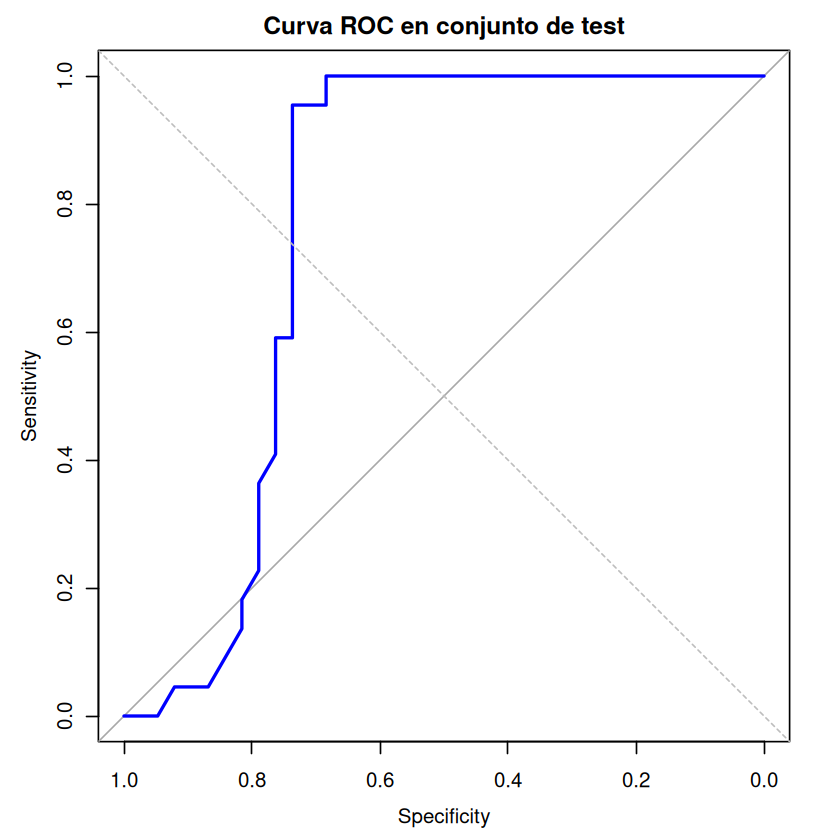

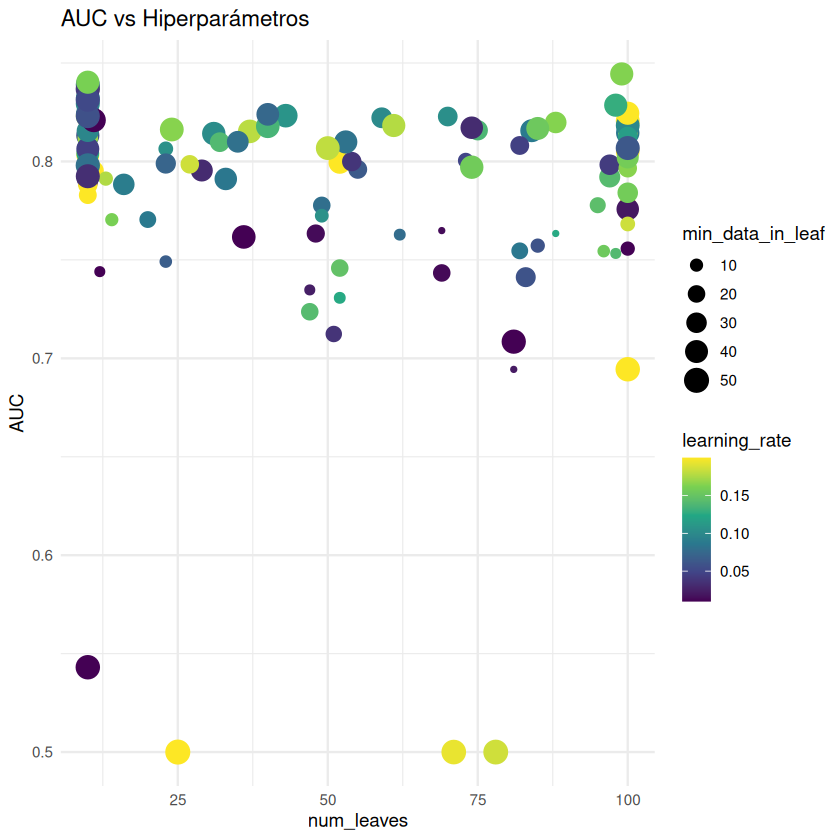

In [30]:
# Paso 14: Entrenamiento final y evaluación en test
# Entrenamos modelo con los mejores hiperparámetros encontrados
dbest <- lgb.train(params = modifyList(param_base, as.list(run$x)),
                   data = dtrain,
                   nrounds = 100)

# Predicciones en el conjunto de test
y_pred <- predict(dbest, data.matrix(test[, !"target", with=FALSE]))

# Cálculo de AUC en test
if (!require("pROC")) install.packages("pROC")
library(pROC)
auc_final <- auc(test$target, y_pred)
cat("AUC en conjunto de test:", auc_final, "
")

# Gráfico de la curva ROC
roc_obj <- roc(test$target, y_pred)
plot(roc_obj, col = "blue", lwd = 2, main = "Curva ROC en conjunto de test")
abline(a = 0, b = 1, lty = 2, col = "gray")

results <- as.data.table(run$opt.path)
ggplot(results, aes(x = num_leaves, y = y)) +
  geom_point(aes(color = learning_rate, size = min_data_in_leaf)) +
  scale_color_viridis_c() +
  labs(title = "AUC vs Hiperparámetros",
       x = "num_leaves",
       y = "AUC",
       color = "learning_rate",
       size = "min_data_in_leaf") +
  theme_minimal()
